# Predicting the habitability

Objectives are to, in a first place, build a regressive model able to predict the Earth Similarity Index (ESI) which lies between 1 and 0, and, secondly, to build a classification model able to predict the habitability of a planet (between 3 classes : not habitable, conservative habitable and optimistic habitable). 

For the 1st modelisation, different models will be tried, in a supervised framework : Random Forest, XGBoost. Three benchmark models will be used to compare the performances of my model : a Multivariate Linear Regression model, the average of the values, and the sklearn benchmark models from the package of the same name. 

For my classification model, I will try, aswell, a Random Forest and an XGBoost, but my classes are highly unbalanced ; I will try different techniques to deal with that.

For each model, I will do feature extraction to ensure my model can generalize well on new data, check some statistics on my explanatory variables, standardize my train/test and impute missing values under the MAR assumption. I will also apply a resampling method, and an optimization of my meta-parameters.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from skopt import BayesSearchCV
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, r2_score, roc_curve, auc, mean_absolute_error
pd.set_option('display.max_columns', None)

In [5]:
def remove_outliers_all_columns(df: pd.DataFrame):
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1

            condition = (df[column] < (q1 - 1.5 * iqr)) | (df[column] > (q3 + 1.5 * iqr))

            df = df[~condition]

    df = df.reset_index(drop=True)

    return df

def remove_col(df, threshold=30):
    df_num = df.select_dtypes(include=np.number)
    df_non_num = df.select_dtypes(exclude=np.number)
    num_cols_to_drop = [col for col in df_num.columns if (df_num[col].isna().sum() / len(df_num[col])) * 100 > threshold]
    df_num.drop(num_cols_to_drop, axis=1, inplace=True)
    non_num_cols_to_drop = [col for col in df_non_num.columns if (df_non_num[col].isna().sum() / len(df_non_num[col])) * 100 > threshold]
    df_non_num.drop(non_num_cols_to_drop, axis=1, inplace=True)
    print(f'Numeric columns dropped: {num_cols_to_drop}')
    print(f'Non-numeric columns dropped: {non_num_cols_to_drop}')
    return pd.concat([df_non_num, df_num], axis=1)

In [6]:
df = pd.read_csv('data/phl_data.csv') 

I remove columns not related to planets and host stars core characteristics, and first removal of columns with too high missing values percentage

In [6]:
col_to_drop = ['P_NAME', 'S_NAME', 'S_CONSTELLATION', 'P_YEAR', 'S_RA', 'S_DEC', 'hip_name', 'hd_name', 'matched']
df.drop(col_to_drop, axis=1, inplace=True)
df = remove_col(df)

# Remove NaN in P_ESI

df.dropna(subset=['P_ESI'], inplace=True)

Numeric columns dropped: []
Non-numeric columns dropped: ['S_TYPE']


Let's start off my the modelisation of the Earth Similarity Index (ESI) : it's a regression task.

In [7]:
# Split the data into training and testing sets
X = df.drop(['P_ESI', 'P_HABITABLE', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_DENSITY', 'P_RADIUS', 'S_TEMPERATURE', 'P_GRAVITY', 'P_FLUX'], axis = 1)
y = df[['P_ESI']]

# Remove 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

nan_indices_train = X_train[X_train['P_DETECTION'].isna()].index
nan_indices_test = X_test[X_test['P_DETECTION'].isna()].index

# Dropping the NaN rows from X_train, X_test, y_train, and y_test
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

X_test = X_test.drop(nan_indices_test)
y_test = y_test.drop(nan_indices_test)

# Imputation and Encoding

Imputation has to be done carefully : we need to always keep in mind that nothing has to be known about the test set. Hence, when imputing (or scaling), we need to do it on the basis of the training set for both train and test set. 

For numerical features. I'll use the MICE method. It consists in imputing missing values by predicting them using other features from the dataset. It assumes that the data is missing randomly.

- 1/ Choose the number of iterations (k) for the algorithm : it creates as many copies of the raw dataset ; 
- 2/ In each column with missing values : replace missing values with an approximation based on the non-missing values in that column (like the mean). This is temporary ;
- 3/ For the column you want to impute : change the temporary value back to missing ;
- 4/ Build a regression model to predict the column you want to impute based on other features ;
- 5/ Repeat steps 2 to 4 for other columns ;
- 6/ All of that forms 1 iteration : do it k times, at each iteration the predicted value of the temporary prediction for each column will keep improving (continuity between successive iteration, hence 'chained').

https://www.machinelearningplus.com/machine-learning/mice-imputation/

After that, I scale them using StandardScaler.

For categorical features : I will One Hot Encode P_TYPE and P_TYPE_TEMP, creating a column for missing values. I will Frequency Encode P_DETECTION has it has a lot of values, always fitting on train and transforming on train/test. 

Creating a column transformer for  the preprocessing part :
- One Hot Encoding ;
- Imputing ;
- Scaling

In [16]:
import category_encoders as ce

In [9]:
# The two pipelines, for numerical and categorical features (and the different encoders)

numerical_pipeline = Pipeline(
    steps=[
        ('mice_imputation', IterativeImputer(random_state=17, max_iter=10)),
        ('scaler', StandardScaler())]
)

categorical_pipeline = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('one_hot', ce.OneHotEncoder(), ['P_TYPE_TEMP']),
            ('frequency', ce.CountEncoder(normalize=True), ['P_DETECTION', 'P_TYPE'])
        ],
    ))
])

# Combine the two pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, ['P_MASS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION', 'P_IMPACT_PARAMETER', 'P_DISTANCE', 'S_MAG', 'S_DISTANCE', 'S_METALLICITY', 'S_MASS', 'S_RADIUS', 'S_AGE','S_LUMINOSITY', 'P_TEMP_EQUIL']),
        ('categorical', categorical_pipeline, ['P_DETECTION', 'P_TYPE', 'P_TYPE_TEMP']),
    ],
    remainder='passthrough'
)

In [10]:
# Fitting pipeline on training data 

preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('mice_imputation',
                                                  IterativeImputer(random_state=17)),
                                                 ('scaler', StandardScaler())]),
                                 ['P_MASS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS',
                                  'P_ECCENTRICITY', 'P_INCLINATION',
                                  'P_IMPACT_PARAMETER', 'P_DISTANCE', 'S_MAG',
                                  'S_DISTANCE', 'S_METALLICITY', 'S_MASS',
                                  'S_RADIUS', 'S_AGE', 'S_LUMINOSITY',
                                  'P_TEMP_EQUIL']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  ColumnTransformer(transformers=[('one_hot',
                                                                                   OneHotEncoder(),
                                                                                   ['P_TYPE_TEMP']),
                                                                                  ('frequency',
                                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                                normalize=True),
                                                                                   ['P_DETECTION',
                                                                                    'P_TYPE'])]))]),
                                 ['P_DETECTION', 'P_TYPE', 'P_TYPE_TEMP'])])

In [11]:
# using it on training and testing data

prep_train = preprocessor.transform(X_train)
X_train_df = pd.DataFrame(prep_train, index=y_train.index)
X_train_df['esi'] = y_train
X_train_df.dropna(inplace=True)
X_train_df.columns = X_train_df.columns.astype(str)

prep_test = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(prep_test, index=y_test.index)
X_test_df['esi'] = y_test
X_test_df.dropna(inplace=True)
X_test_df.columns = X_test_df.columns.astype(str)

In [12]:
# Checking

print(f'{X_train_df.isna().sum().sum()}')
print(f'{X_test_df.isna().sum().sum()}')

0
0


Checking the distribution of P_ESI

<AxesSubplot: xlabel='P_ESI', ylabel='Count'>

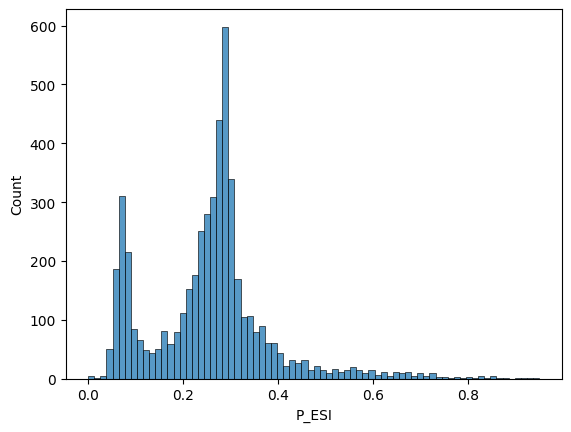

In [11]:
sns.histplot(df, x = 'P_ESI')

# Models

In [15]:
def comb_nb(algorithm_params):
    lst_nb_values = []

    for values in algorithm_params.values():
        lst_nb_values.append(len(values))

    for i in range(len(lst_nb_values)):
        if i == 0:
            lst_nb_values[i] = lst_nb_values[i]
        else:
            lst_nb_values[i] = (lambda x, y: x * y)(lst_nb_values[i-1], lst_nb_values[i])    
    return f'{lst_nb_values[-1]*5} combinations have to be tested.'

As a benchmark, I will do a Linear Regression. Then, I will compare it with a Random Forest and XGBoost, as state-of-the-art models.

In [43]:
model_fitted = RandomForestRegressor(n_estimators=100, random_state=17).fit(X_train_df.drop(['esi'], axis =1), X_train_df[['esi']])

c:\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


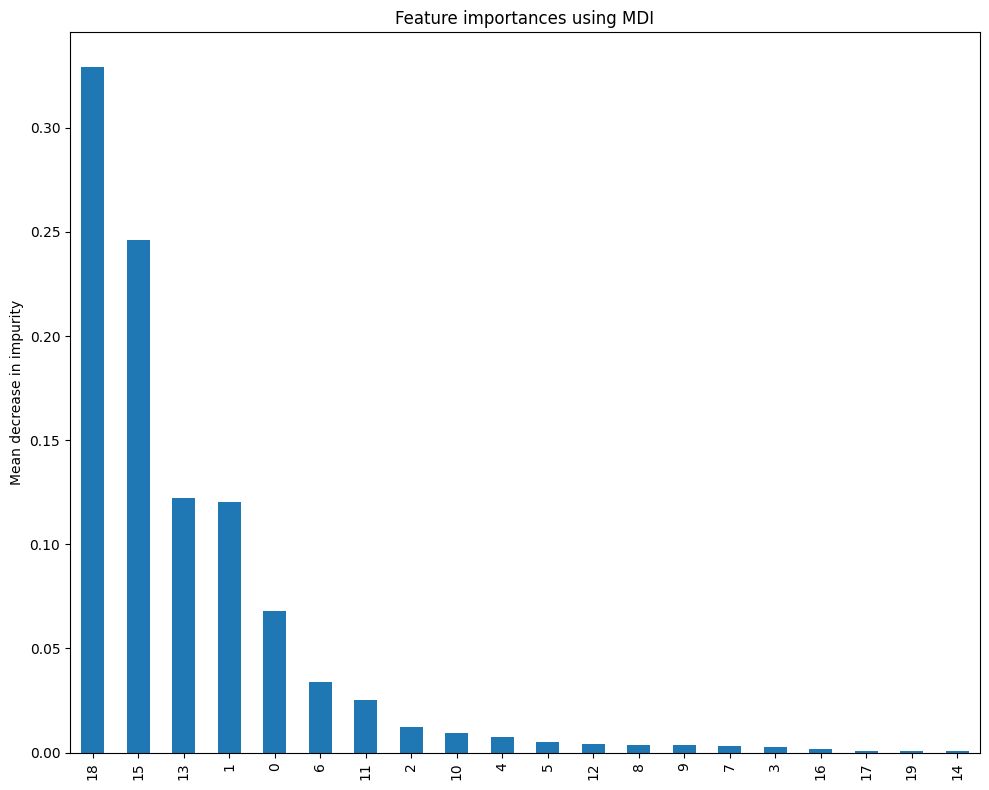

In [45]:
# Feature importance

importances = model_fitted.feature_importances_
feature_importances = pd.Series(importances, index=X_train_df.drop(['esi'],axis=1).columns).sort_values(ascending=False)

# Plot

fig, ax = plt.subplots(figsize=(10,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
from sklearn.linear_model import LassoCV

In [47]:
lasso_model = LassoCV(random_state=17)
cv_folds = KFold(n_splits=5, shuffle=True, random_state=17)

algorithm_params = {'alphas': [[0.02], [0.03]]}

In [48]:
comb_nb(algorithm_params)

'10 combinations have to be tested.'

In [49]:
grid_search = GridSearchCV(lasso_model, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X_train_df.drop(['esi'], axis = 1), X_train_df[['esi']].values.ravel())

best_model_grid_search = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'alphas': [0.02]}


In [51]:
y_pred = best_model_grid_search.predict(X_test_df.drop(['esi'], axis = 1))
mse = mean_squared_error(y_true = X_test_df[['esi']], y_pred=y_pred)
r2_square = r2_score(y_true=X_test_df[['esi']], y_pred=y_pred)
mae = mean_absolute_error(y_true=X_test_df[['esi']], y_pred=y_pred)
print(f'RMSE: {np.sqrt(mse)}')
print(f"Model MSE for : {mse} ")
print(f'MAE: {mae}')
print(f"Model R2 for : {r2_square} ")

RMSE: 0.12411161342190119
Model MSE for : 0.015403692586187444 
MAE: 0.08471140803969046
Model R2 for : 0.1028160550301841 


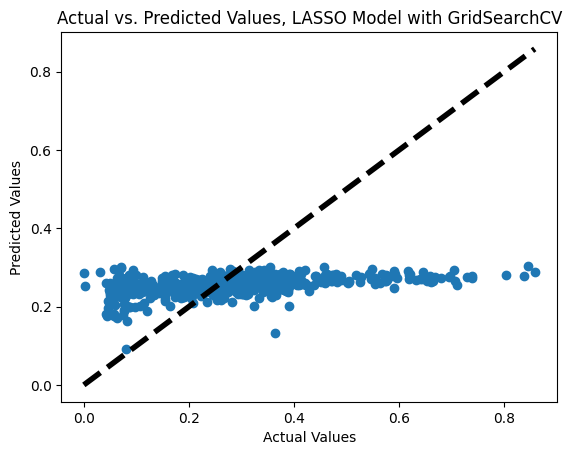

In [52]:
# Scatter Plot

plt.scatter(X_test_df[['esi']], y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values, LASSO Model with GridSearchCV')
plt.plot([X_test_df[['esi']].min(), X_test_df[['esi']].max()], [X_test_df[['esi']].min(), X_test_df[['esi']].max()], 'k--', lw=4) 
plt.show()

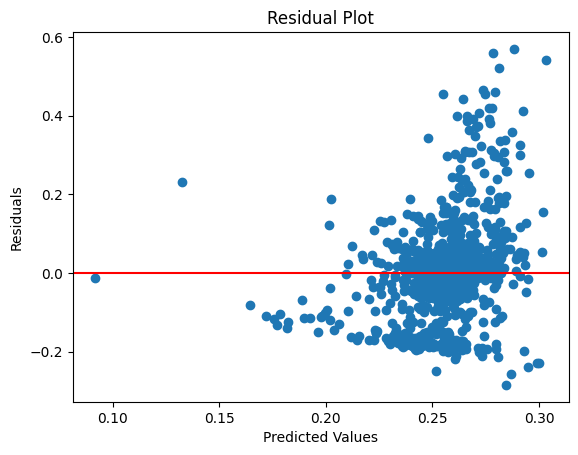

In [54]:
# Residuals

plt.scatter(y_pred, (X_test_df['esi'] - y_pred))
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [55]:
rf_model = RandomForestRegressor(random_state=17)
cv_folds = KFold(n_splits=5, shuffle=True, random_state=17)

algorithm_params = {'n_estimators': list(range(100,500,50)),
                 'max_depth': list(range(3,20,2)),
                 'min_samples_split': list(range(2,20)), 
                 'min_samples_leaf': list(range(1,20)),
}

In [56]:
comb_nb(algorithm_params)

'123120 combinations have to be tested.'

In [57]:
bayesian_search = BayesSearchCV(rf_model, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_train_df.drop(['esi'], axis = 1), X_train_df[['esi']].values.ravel())

BayesSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
              estimator=RandomForestRegressor(random_state=17), n_iter=100,
              n_jobs=-1, random_state=17, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19],
                             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19],
                             'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                              450]})

In [58]:
best_model_bayesian = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

Best parameters: OrderedDict([('max_depth', 19), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 250)])


In [59]:
y_pred = best_model_bayesian.predict(X_test_df.drop(['esi'], axis = 1))
mse = mean_squared_error(y_true = X_test_df[['esi']], y_pred=y_pred)
r2_square = r2_score(y_true=X_test_df[['esi']], y_pred=y_pred)
mae = mean_absolute_error(y_true=X_test_df[['esi']], y_pred=y_pred)
print(f'RMSE: {np.sqrt(mse)}')
print(f"Model MSE for : {mse} ")
print(f'MAE: {mae}')
print(f"Model R2 for : {r2_square} ")

RMSE: 0.02754747870965774
Model MSE for : 0.0007588635832590463 
MAE: 0.014913605293854252
Model R2 for : 0.9558001940435507 


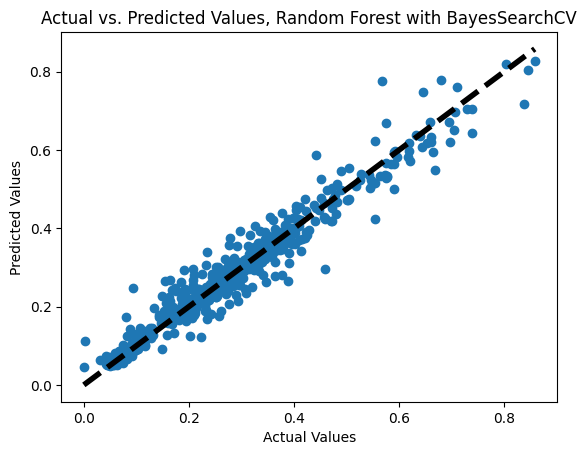

In [60]:
# Scatter Plot

plt.scatter(X_test_df[['esi']], y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values, Random Forest with BayesSearchCV')
plt.plot([X_test_df[['esi']].min(), X_test_df[['esi']].max()], [X_test_df[['esi']].min(), X_test_df[['esi']].max()], 'k--', lw=4) 
plt.show()

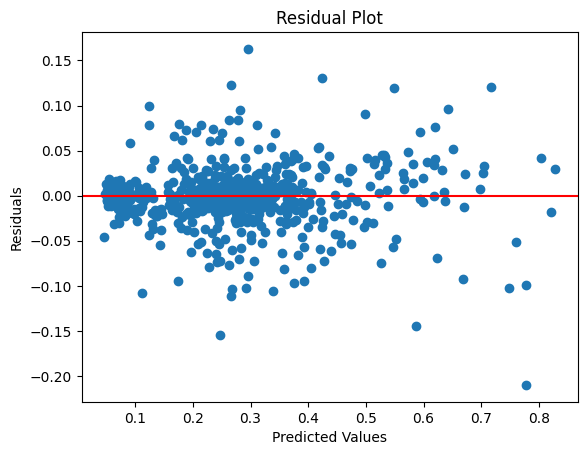

In [61]:
# Residuals

plt.scatter(y_pred, (X_test_df['esi'] - y_pred))
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [13]:
import xgboost as xgb

In [63]:
xgb_model = xgb.XGBRegressor()
cv_folds = KFold(n_splits=5, shuffle=True, random_state=17)

algorithm_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],  
    "max_depth": list(range(3, 13)), 
    "min_child_weight": list(range(1, 10)), 
    "gamma": [0.0, 0.05, 0.1, 0.15, 0.2],  
    "colsample_bytree": [i/10.0 for i in range(3, 11)]  
}

In [65]:
comb_nb(algorithm_params)

'162000 combinations have to be tested.'

In [64]:
bayesian_search = BayesSearchCV(xgb_model, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_train_df.drop(['esi'], axis = 1), X_train_df[['esi']].values.ravel())

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

Best parameters: OrderedDict([('colsample_bytree', 0.7), ('gamma', 0.0), ('learning_rate', 0.15), ('max_depth', 10), ('min_child_weight', 8)])


In [68]:
y_pred = best_model.predict(X_test_df.drop(['esi'], axis = 1))
mse = mean_squared_error(y_true = X_test_df[['esi']], y_pred=y_pred)
r2_square = r2_score(y_true=X_test_df[['esi']], y_pred=y_pred)
mae = mean_absolute_error(y_true=X_test_df[['esi']], y_pred=y_pred)
print(f'RMSE: {np.sqrt(mse)}')
print(f"MSE: {mse} ")
print(f'MAE: {mae}')
print(f"R2: {r2_square} ")

RMSE: 0.02455691458124783
MSE: 0.0006030420537507023 
MAE: 0.013674286417401272
R2: 0.9648759772541873 


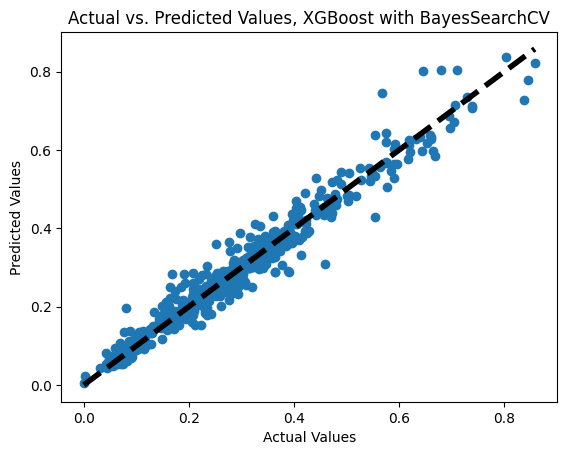

In [69]:
# Scatter Plot

plt.scatter(X_test_df[['esi']], y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values, XGBoost with BayesSearchCV')
plt.plot([X_test_df[['esi']].min(), X_test_df[['esi']].max()], [X_test_df[['esi']].min(), X_test_df[['esi']].max()], 'k--', lw=4) 
plt.show()

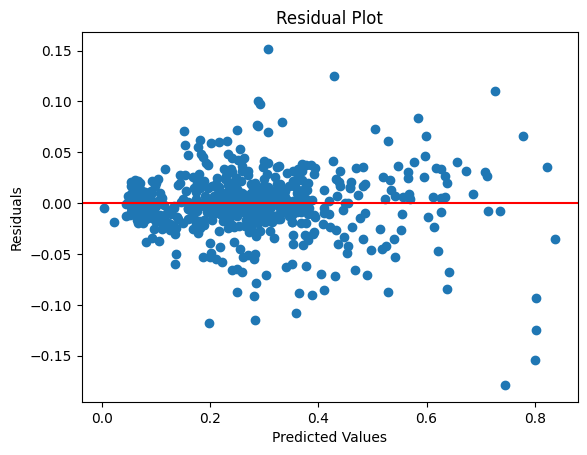

In [70]:
# Residuals

plt.scatter(y_pred, pd.Series(X_test_df['esi'] - y_pred))
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Predict the P_HABITABLE column

In [17]:
from sklearn.metrics import f1_score

In [18]:
df = pd.read_csv('data/phl_data.csv') 

In [19]:
col_to_drop = ['S_NAME', 'S_CONSTELLATION', 'P_YEAR', 'S_RA', 'S_DEC', 'hip_name', 'hd_name', 'matched']
df.drop(col_to_drop, axis=1, inplace=True)
df = remove_col(df)

# Remove NaN in P_ESI

df.dropna(subset=['P_ESI'], inplace=True)

Numeric columns dropped: []
Non-numeric columns dropped: ['S_TYPE']


In [20]:
# Split the data into training and testing sets
X = df.drop(['P_ESI', 'P_HABITABLE', 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_DISTANCE'], axis = 1)
y = df[['P_HABITABLE']]

# Remove 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

x_train_p_names = X_train['P_NAME']
X_train.drop(['P_NAME'], axis = 1, inplace = True)

nan_indices_train = X_train[X_train['P_DETECTION'].isna()].index
nan_indices_test = X_test[X_test['P_DETECTION'].isna()].index

# Dropping the NaN rows from X_train, X_test, y_train, and y_test
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

X_test = X_test.drop(nan_indices_test)
y_test = y_test.drop(nan_indices_test)

In [21]:
numerical_pipeline = Pipeline(
    steps=[
        ('mice_imputation', IterativeImputer(random_state=17, max_iter=10)),
        ('scaler', StandardScaler())]
)

categorical_pipeline = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['P_TYPE_TEMP', 'P_TYPE']),
            ('frequency', ce.CountEncoder(normalize=True), ['P_DETECTION'])
        ]
    ))
])

# Combine the two pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION', 'P_IMPACT_PARAMETER', 'P_FLUX', 'P_DENSITY', 'P_GRAVITY', 'S_MAG', 'S_DISTANCE', 'S_METALLICITY', 'S_MASS', 'S_RADIUS', 'S_AGE', 'S_TEMPERATURE','S_LUMINOSITY', 'P_TEMP_EQUIL']),
        ('categorical', categorical_pipeline, ['P_DETECTION', 'P_TYPE_TEMP', 'P_TYPE']),
    ],
    remainder='passthrough'
)

In [22]:
# Fitting pipeline on training data 

preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('mice_imputation',
                                                  IterativeImputer(random_state=17)),
                                                 ('scaler', StandardScaler())]),
                                 ['P_MASS', 'P_RADIUS', 'P_PERIOD',
                                  'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY',
                                  'P_INCLINATION', 'P_IMPACT_PARAMETER',
                                  'P_FLUX', 'P_DENSITY', 'P_GRAVITY', 'S_MAG',
                                  'S_DISTANCE', 'S_METALLICITY', 'S_MA...
                                  'S_RADIUS', 'S_AGE', 'S_TEMPERATURE',
                                  'S_LUMINOSITY', 'P_TEMP_EQUIL']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  ColumnTransformer(transformers=[('one_hot',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['P_TYPE_TEMP',
                                                                                    'P_TYPE']),
                                                                                  ('frequency',
                                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                                normalize=True),
                                                                                   ['P_DETECTION'])]))]),
                                 ['P_DETECTION', 'P_TYPE_TEMP', 'P_TYPE'])])

In [23]:
# using it on training and testing data

prep_train = preprocessor.transform(X_train)
X_train_df = pd.DataFrame(prep_train, index=y_train.index)
X_train_df['P_HABITABLE'] = y_train
X_train_df.dropna(inplace=True)
X_train_df.columns = X_train_df.columns.astype(str)

prep_test = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(prep_test, index=y_test.index)
X_test_df['P_HABITABLE'] = y_test
X_test_df.dropna(inplace=True)
X_test_df.columns = X_test_df.columns.astype(str)

In [24]:
X_train = X_train_df.drop(['P_HABITABLE'], axis = 1)
y_train = X_train_df[['P_HABITABLE']]

X_test = X_test_df.drop(['P_HABITABLE'], axis = 1)
y_test = X_test_df[['P_HABITABLE']]

Text(0.5, 1.0, 'Test Imbalanced')

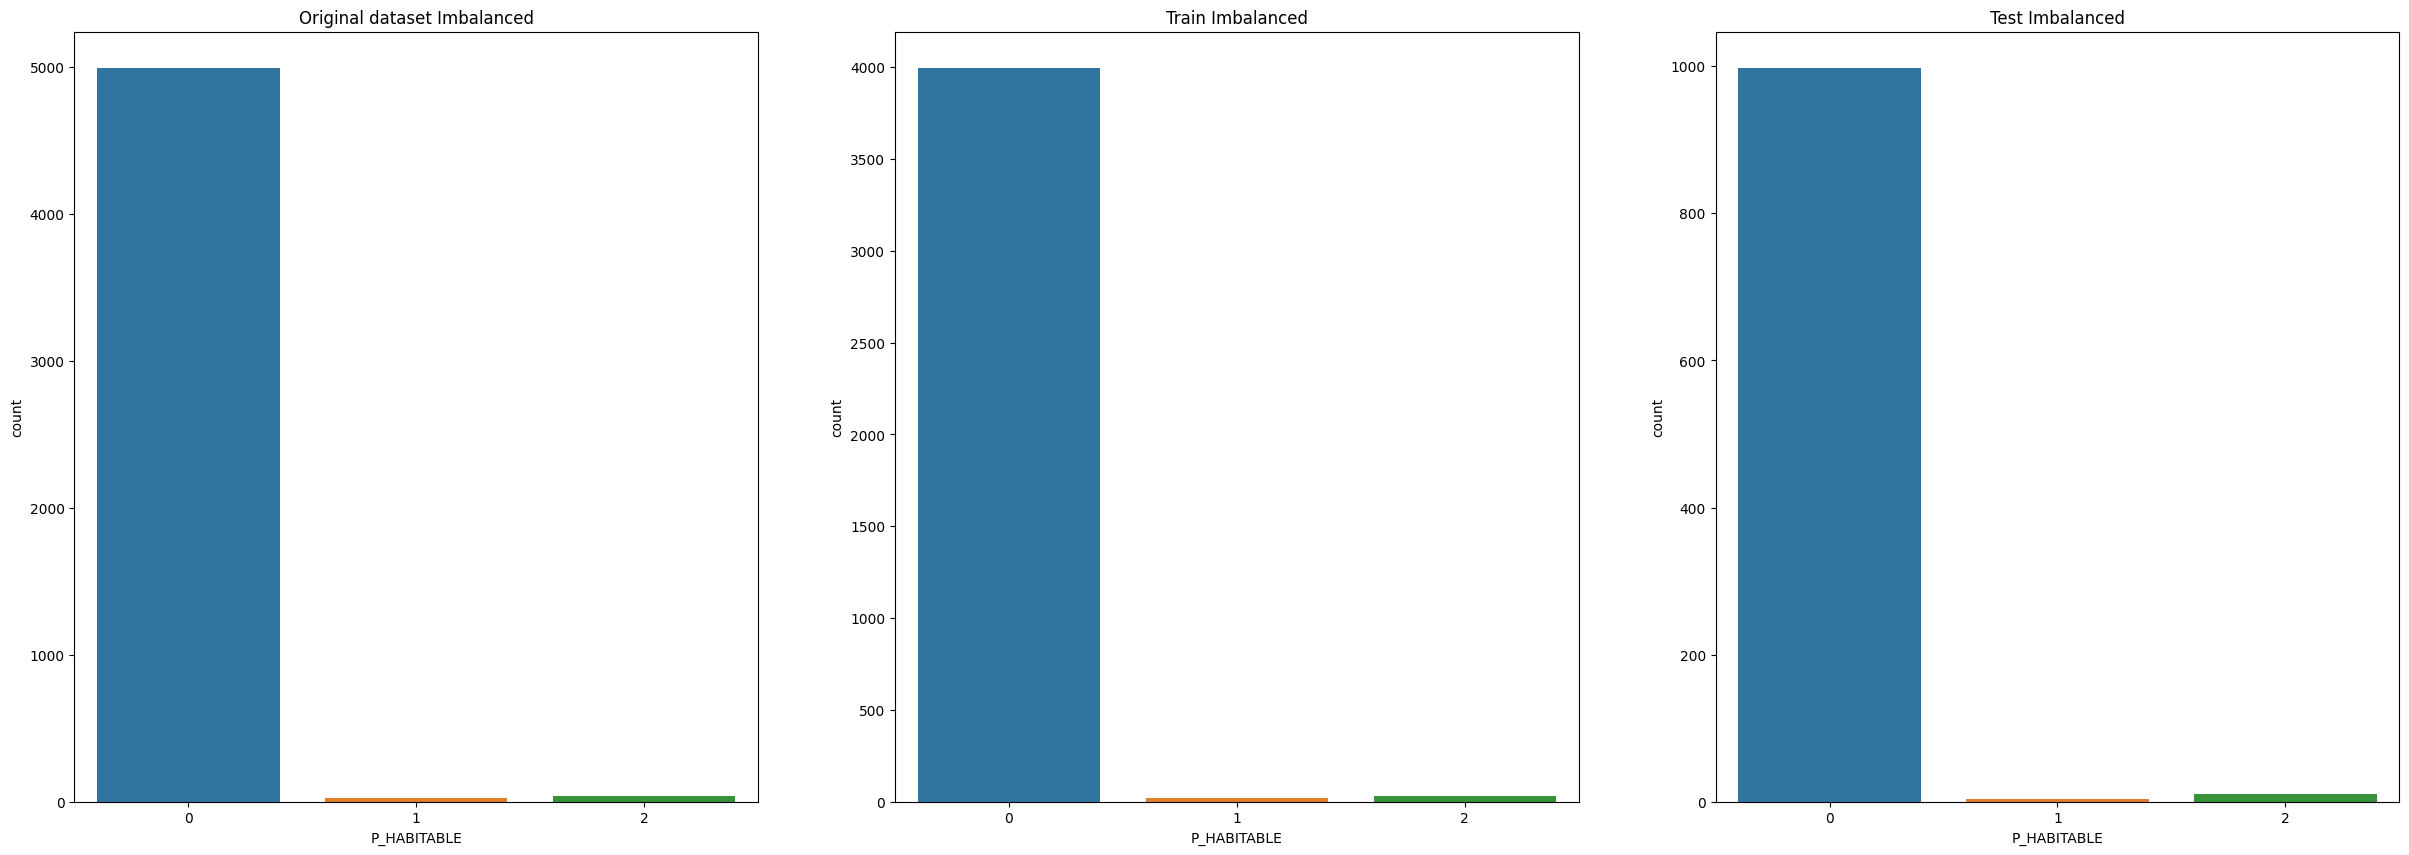

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
sns.countplot(df, x = 'P_HABITABLE', ax=ax1)
ax1.set_title('Original dataset Imbalanced')
sns.countplot(X_train_df, x = 'P_HABITABLE', ax=ax2)
ax2.set_title('Train Imbalanced')
sns.countplot(X_test_df, x = 'P_HABITABLE', ax=ax3)
ax3.set_title('Test Imbalanced')

c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


KeyboardInterrupt: 

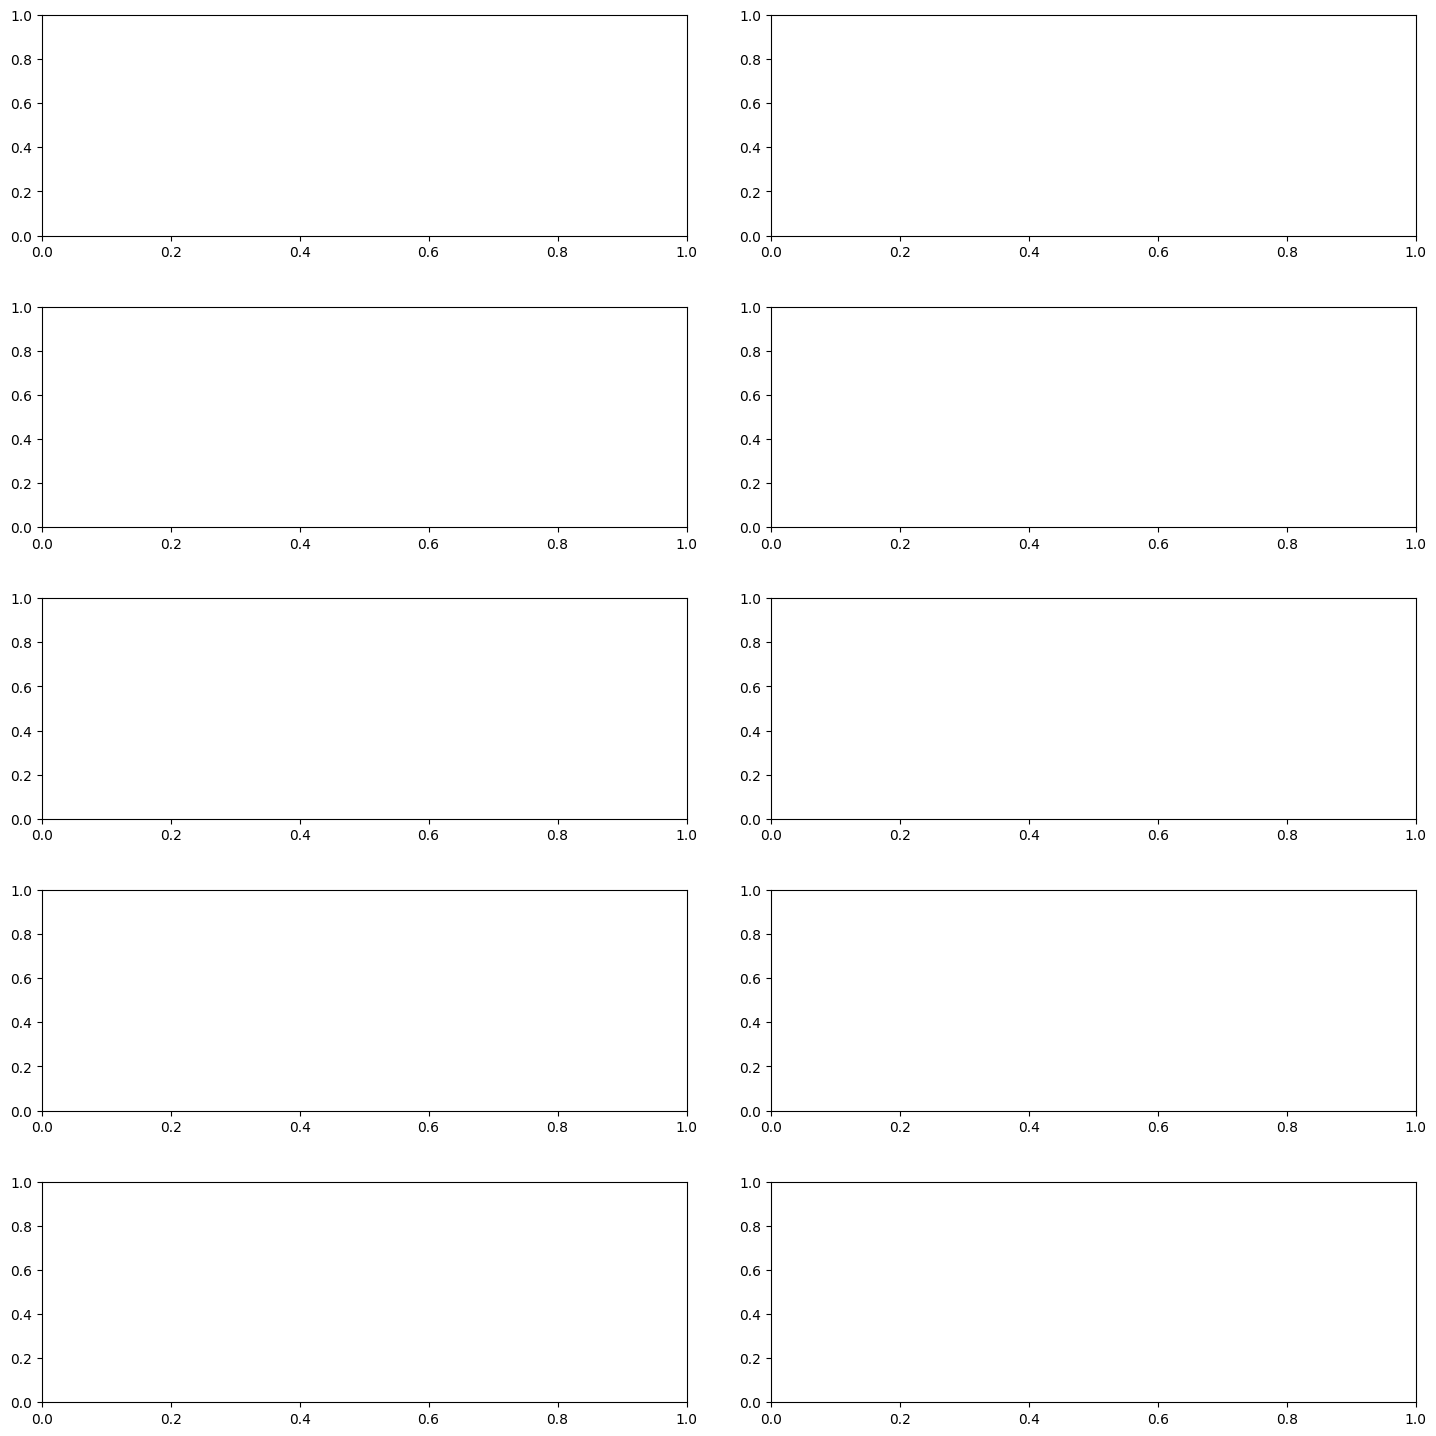

In [26]:
# t-SNE for 2-D Visualization

from sklearn.manifold import TSNE

scaler = StandardScaler()

fig, axs = plt.subplots(5, 2, figsize=(15, 3 * 5))
fig.tight_layout(pad=3.0)
axs = axs.flatten()
y_train_2 = y_train.copy()

for i, ax in enumerate(axs, start=5):
    if i > 50:
        ax.axis('off')
        continue
    
    df_scaled = scaler.fit_transform(X_train)
    df_scaled = pd.DataFrame(df_scaled, columns=X_train.columns)

    tsne = TSNE(n_components=2, perplexity=i, random_state=17)
    coord_tsne = tsne.fit_transform(df_scaled)

    y_train_2['tsne_1'] = coord_tsne[:,0]
    y_train_2['tsne_2'] = coord_tsne[:,1]

    y_train_2['P_NAME'] = x_train_p_names

    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='P_HABITABLE', 
        data=y_train_2,
        ax=ax
    )

    for index, row in y_train_2[y_train_2['P_HABITABLE'] == 1].iterrows():
        if row['P_NAME'] == 'TRAPPIST-1 d':
            ax.annotate(row['P_NAME'], (row['tsne_1'], row['tsne_2']), fontsize=9, alpha=0.7)

    y_train_2.drop(['P_NAME'], axis = 1, inplace=True)

plt.show()

Try Mahalanobis Distance to detect outliers and see if we can detect TRAPPIST-1 d. Then we shortly describe it.

In [27]:
def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    
    return mahal.diagonal()

In [28]:
X_train['mahalanobis'] = mahalanobis(X_train, X_train)

c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [29]:
X_train['P_NAME'] = x_train_p_names

In [30]:
from scipy.stats import chi2

In [31]:
X_train['p'] = 1 - chi2.cdf(X_train['mahalanobis'], X_train.shape[1]-1)

In [32]:
## Choose p-value < 0.05

X_train[X_train['P_NAME'] == 'TRAPPIST-1 d']

# TRAPPIST-1 d is indeed an outlier, but also the third highest ESI in our dataframe! 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,mahalanobis,P_NAME,p
4942,-0.111164,-0.893521,-0.01656,-0.04782,-0.05717,0.019139,0.015372,-0.047795,-0.004126,-0.265394,1.436785,-1.059562,0.166433,-1.947493,-0.364701,-0.404278,-1.936886,-0.066719,-1.094137,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.776485,1.0,110.536333,TRAPPIST-1 d,1.418156e-10


In [33]:
df_habitable_1 = df[df['P_HABITABLE']==1]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12372\1645629699.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_habitable_1[col], ax=ax, shade=True)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12372\1645629699.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_habitable_1[col], ax=ax, shade=True)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12372\1645629699.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_habitable_1[col], ax=ax, shade=True)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12372\1645629699.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fi

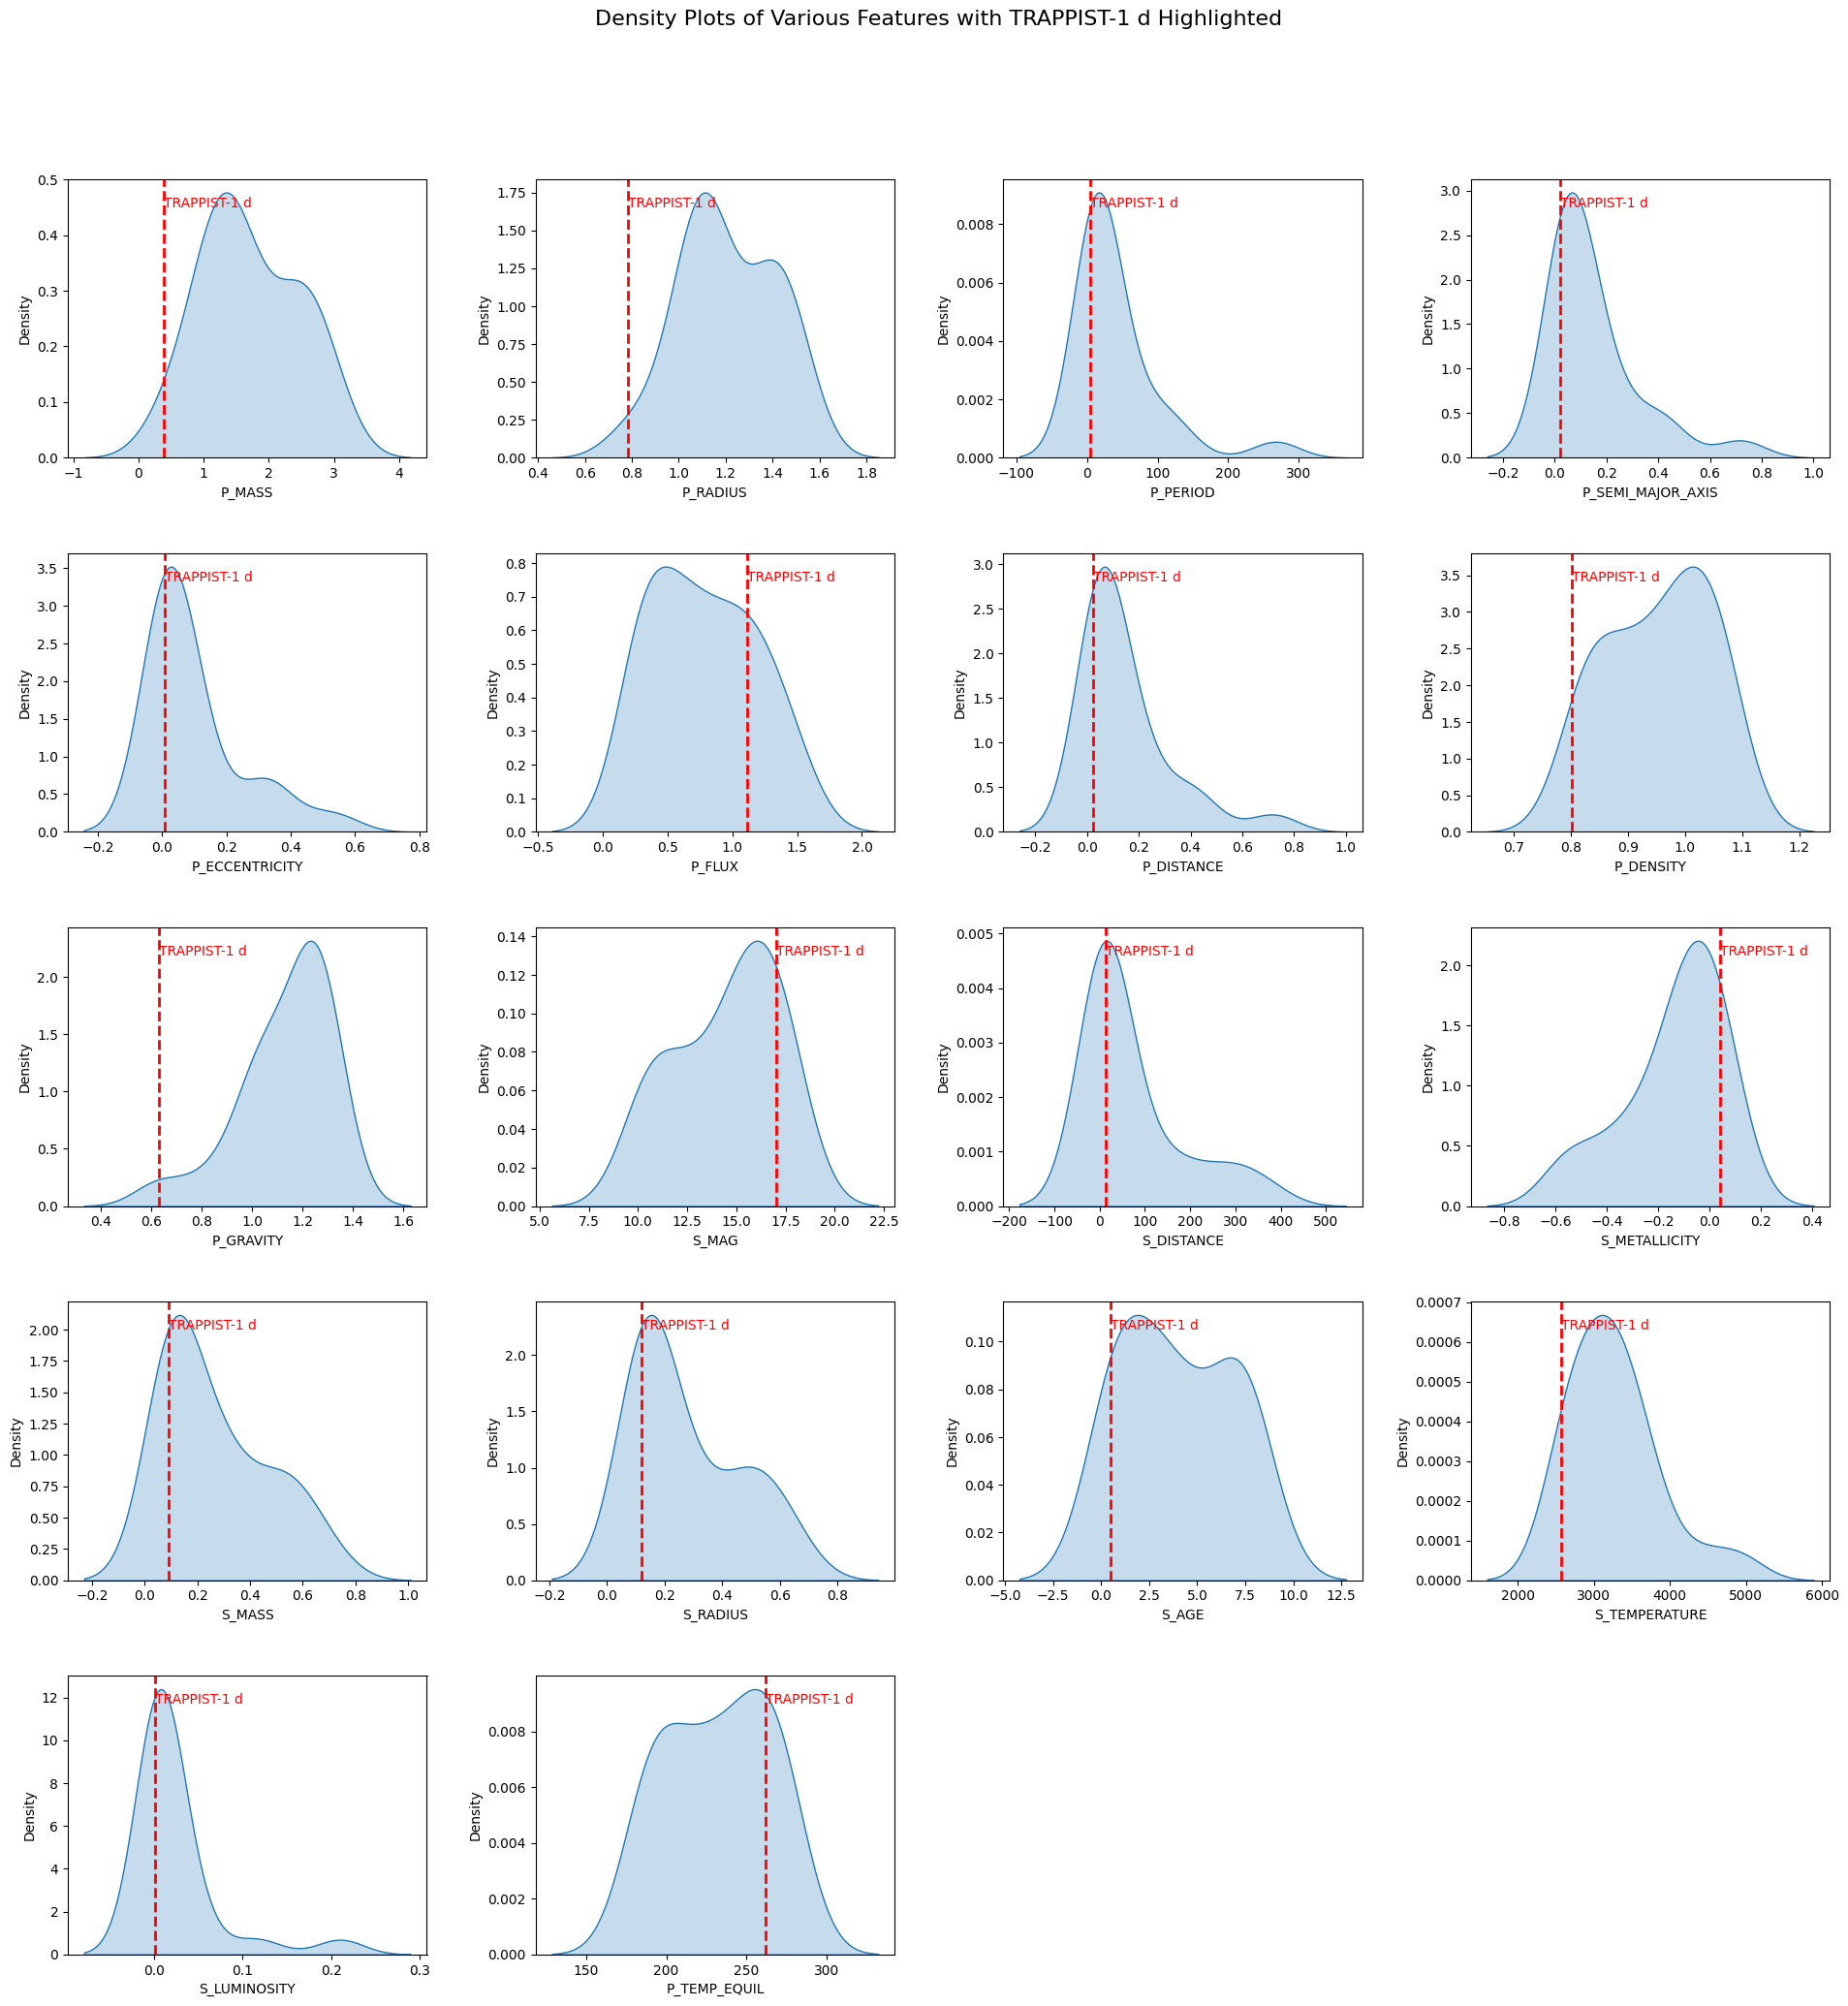

In [34]:
columns = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
           'P_FLUX', 'P_DISTANCE', 'P_DENSITY', 'P_GRAVITY', 'S_MAG', 'S_DISTANCE', 
           'S_METALLICITY', 'S_MASS', 'S_RADIUS', 'S_AGE', 'S_TEMPERATURE', 'S_LUMINOSITY', 'P_TEMP_EQUIL']

trappist_1d_values = {col: df_habitable_1[df_habitable_1['P_NAME'] == 'TRAPPIST-1 d'][col].iloc[0] for col in columns}

n_rows = 5
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for i, col in enumerate(columns):
    ax = axes[i//n_cols, i%n_cols]
    sns.kdeplot(df_habitable_1[col], ax=ax, shade=True)
    ax.axvline(trappist_1d_values[col], color='red', linestyle='dashed', linewidth=2)
    ax.text(trappist_1d_values[col], ax.get_ylim()[1]*0.9, 'TRAPPIST-1 d', color='red')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

for i in range(len(columns), n_rows*n_cols):
    axes[i//n_cols, i%n_cols].axis('off')

plt.suptitle('Density Plots of Various Features with TRAPPIST-1 d Highlighted', fontsize=16, y=1.05)

plt.show()

Need to specify this unbalance in the algorithm creation. 
- In a first place, I will use a stratified version of KFolds, and a weight on the classes in the classifier;
- Try a method based on resampling : SMOTE algorithm;
- Try a method based on cost function : AdaCost; 

Then, the usual models to classify for the SMOTE:
- Benchmark Model : DummyClassifier;
- RandomForestClassifier;
- XGBoost;

Then, use appropriate metrics to asses the quality of the classification on my unbalanced dataset.

# ADASYN

In [37]:
X_train.drop(['P_NAME', 'mahalanobis', 'p'], axis = 1, inplace=True)

In [38]:
from imblearn.over_sampling import ADASYN
from collections import Counter

print("Class distribution before ADASYN:", Counter(y_train['P_HABITABLE']))

oversample = ADASYN(sampling_strategy='auto', random_state=17)
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", Counter(y_resampled['P_HABITABLE']))

Class distribution before ADASYN: Counter({0: 3993, 2: 29, 1: 18})
Class distribution after SMOTE: Counter({1: 3994, 2: 3994, 0: 3993})


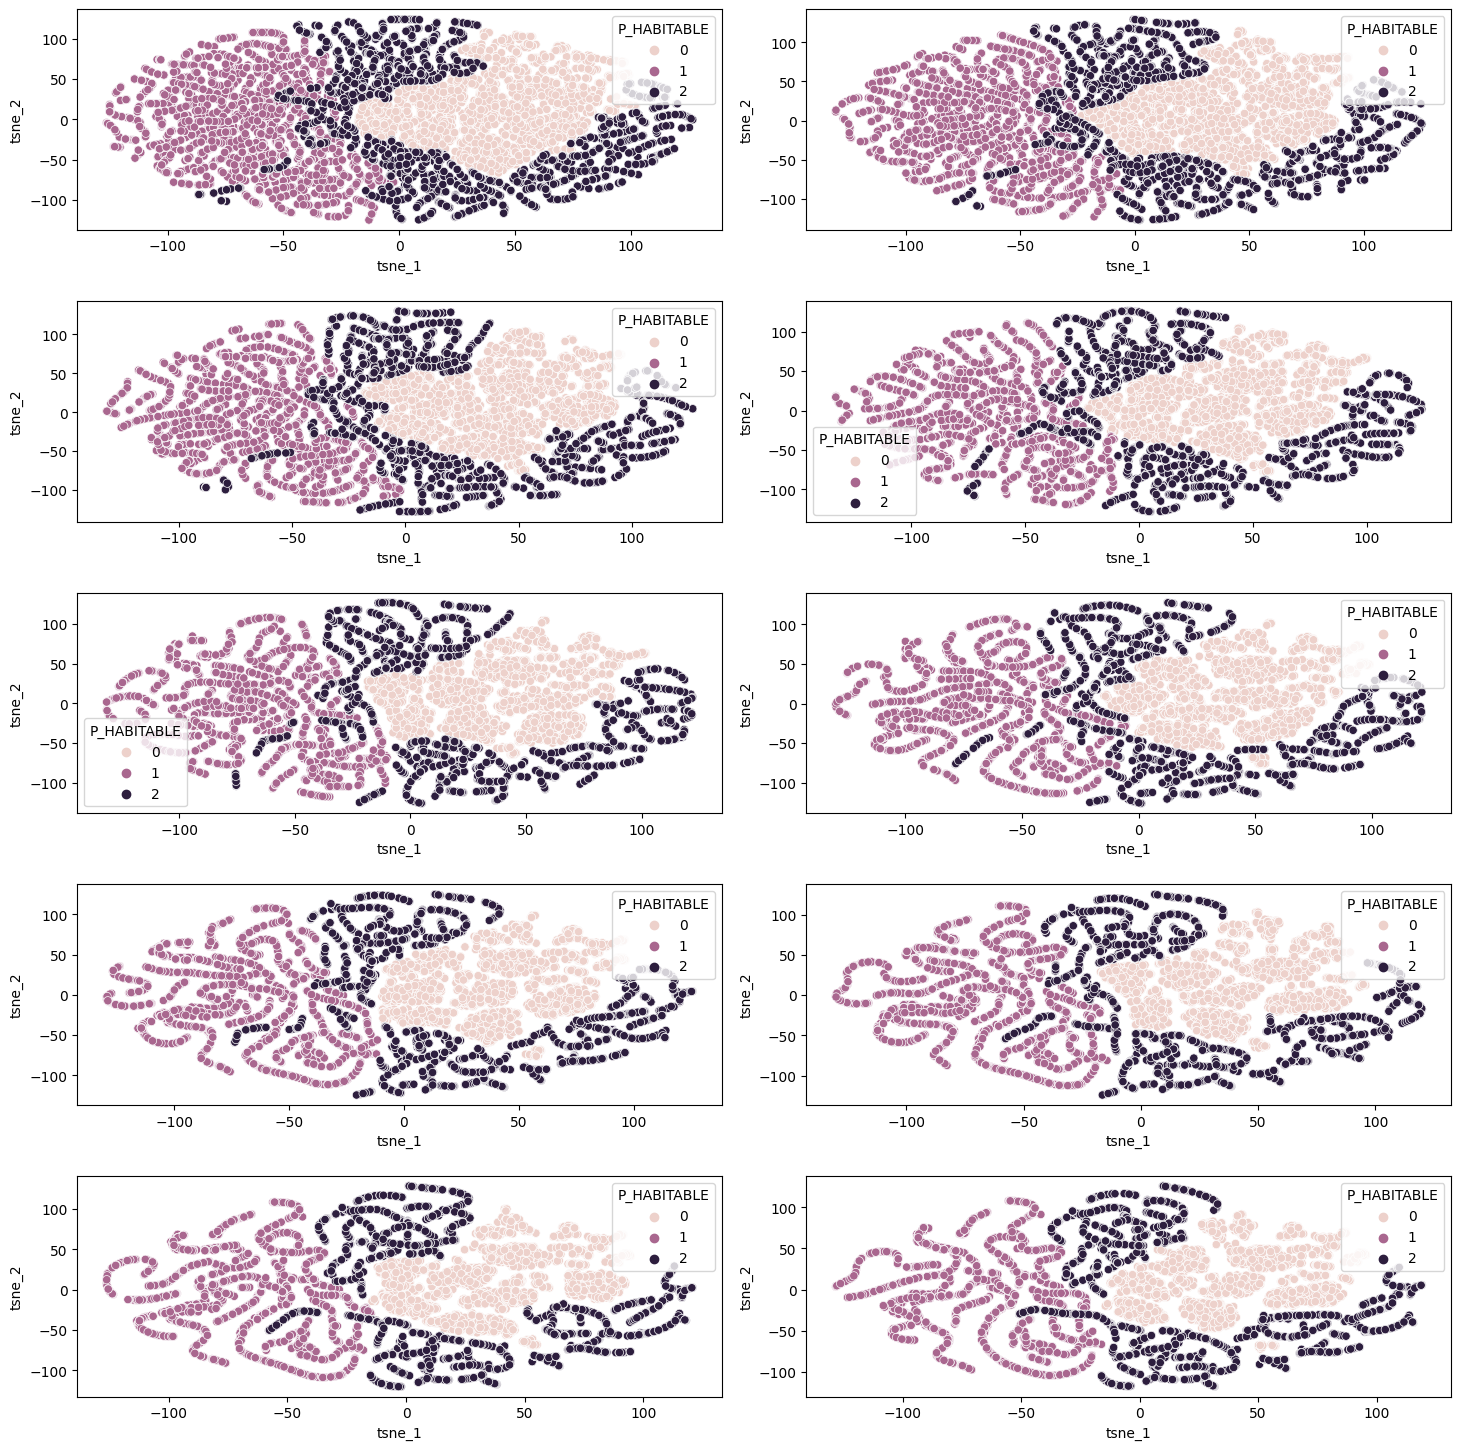

In [95]:
# t-SNE visualization after oversampling

fig, axs = plt.subplots(5, 2, figsize=(15, 3 * 5))
fig.tight_layout(pad=3.0)
axs = axs.flatten()
y_resampled_2 = y_resampled.copy()

for i, ax in enumerate(axs, start=5):
    if i > 50:
        ax.axis('off')
        continue

    scaler = StandardScaler()
    
    df_scaled = scaler.fit_transform(X_resampled)
    df_scaled = pd.DataFrame(df_scaled, columns=X_resampled.columns)

    tsne = TSNE(n_components=2, perplexity=i, random_state=17)
    coord_tsne = tsne.fit_transform(df_scaled)

    y_resampled_2['tsne_1'] = coord_tsne[:,0]
    y_resampled_2['tsne_2'] = coord_tsne[:,1]

    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='P_HABITABLE', 
        data=y_resampled_2,
        ax=ax
    )

plt.show()

Feature Extraction with ADASYN as re-balancing method

In [39]:
model_fitted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=17).fit(X_resampled, y_resampled)

# Evaluation of the model

y_pred = model_fitted.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

c:\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.0


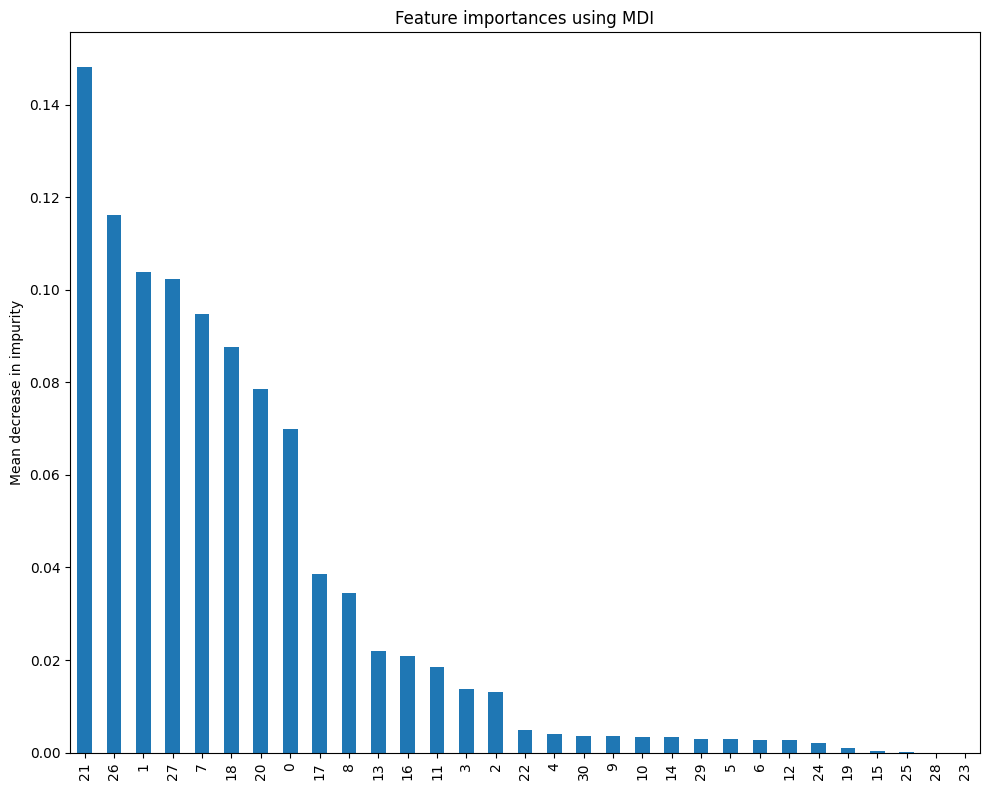

In [40]:
# Feature importance

importances = model_fitted.feature_importances_
feature_importances = pd.Series(importances, index=X_resampled.columns).sort_values(ascending=False)

# Plot

fig, ax = plt.subplots(figsize=(10,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [41]:
X_resampled = X_resampled[['21', '26', '1', '7', '20', '27', '0', '14', '17', '18', '9']]
X_test_resampled = X_test[['21', '26', '1', '7', '20', '27', '0', '14', '17', '18', '9']]

Benchmark : I will use the DummyClassifier from sklearn.dummy

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_resampled, y_resampled)

In [43]:
y_pred = dummy_clf.predict(X_test_resampled)
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
f1_score_ = f1_score(y_true = y_test.astype(float), y_pred=y_pred.astype(float), average='macro')
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")
print(f'f1 score : {f1_score_}')

Model Accuracy : 0.003956478733926805
Model Precision : 0.003996003996003996 
Model Sensitivity : 1.0 
f1 score : 0.0026272577996715924


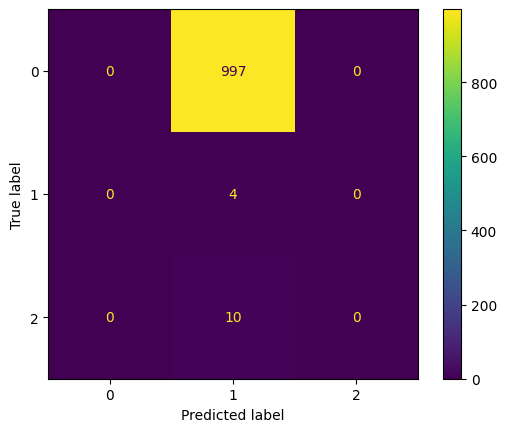

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

RandomForestClassifier

In [45]:
srf = RandomForestClassifier(random_state=17, class_weight='balanced')
cv_folds = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=17)

algorithm_params = {'n_estimators': list(range(100,500,50)),
                 'max_depth': list(range(3,20,2)),
                 'min_samples_split': list(range(2,20)), 
                 'min_samples_leaf': list(range(1,20)),
}

In [46]:
comb_nb(algorithm_params)

'123120 combinations have to be tested.'

In [47]:
bayesian_search = BayesSearchCV(srf, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_resampled, y_resampled)

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

c:\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters: OrderedDict([('max_depth', 15), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 200)])


In [48]:
y_pred = best_model.predict(X_test_resampled)
# Evaluate model performance
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
f1_score_ = f1_score(y_true = y_test.astype(float), y_pred=y_pred.astype(float), average='macro')
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")
print(f'f1 score : {f1_score_}')

Model Accuracy : 1.0
Model Precision : 1.0 
Model Sensitivity : 1.0 
f1 score : 1.0


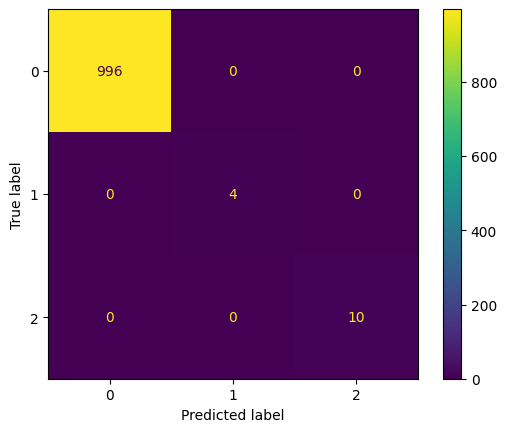

In [116]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

Try wih XGBoost Classifier

In [117]:
xgb_model = xgb.XGBClassifier()
cv_folds = KFold(n_splits=5, shuffle=True, random_state=17)

algorithm_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],  
    "max_depth": list(range(3, 13)), 
    "min_child_weight": list(range(1, 10)), 
    "gamma": [0.0, 0.05, 0.1, 0.15, 0.2],  
    "colsample_bytree": [i/10.0 for i in range(3, 11)]  
}

In [61]:
comb_nb(algorithm_params)

'162000 combinations have to be tested.'

In [62]:
bayesian_search = BayesSearchCV(xgb_model, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_resampled, y_resampled)

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

Best parameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.05), ('learning_rate', 0.01), ('max_depth', 10), ('min_child_weight', 9)])


In [63]:
y_pred = best_model.predict(X_test_resampled)
# Evaluate model performance
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
f1_score_ = f1_score(y_true = y_test.astype(float), y_pred=y_pred.astype(float), average='macro')
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")
print(f'f1 score : {f1_score_}')

Model Accuracy : 1.0
Model Precision : 1.0 
Model Sensitivity : 1.0 


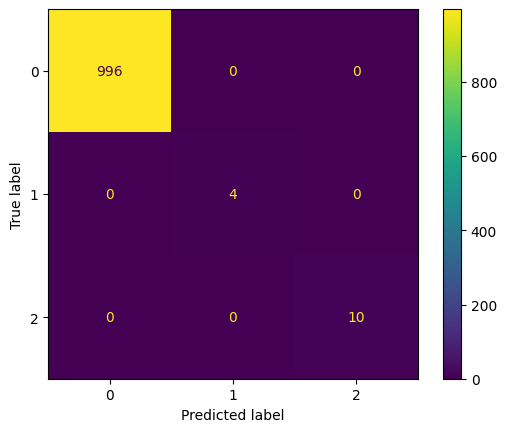

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# ADACOST method for re-balancing

In [85]:
from imbens.ensemble import AdaCostClassifier

Feature Extraction

In [87]:
adacost = AdaCostClassifier(random_state = 17).fit(X_train, y_train)
# Evaluation of the model

y_pred = adacost.predict(X_test)
score = adacost.score(X_test, y_test)
print(f"Score: {score}")

Score: 0.996039603960396


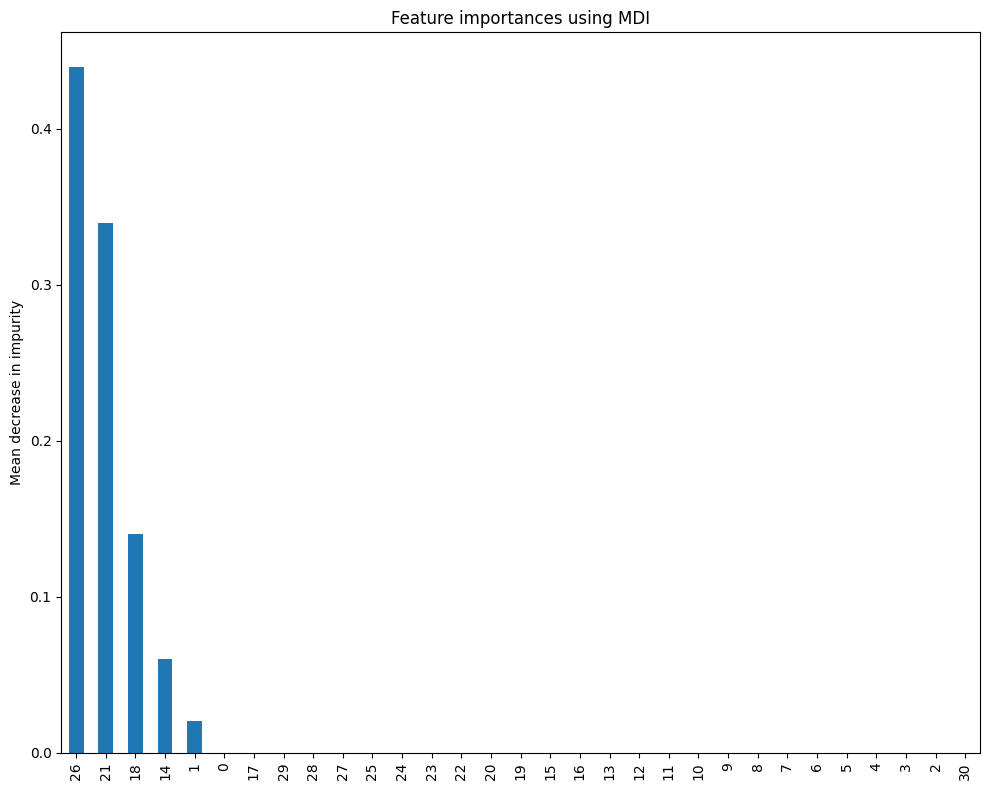

In [88]:
# Feature importance

importances = adacost.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Plot

fig, ax = plt.subplots(figsize=(10,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [89]:
x_train = X_train[['26', '21', '18', '14', '1']]
x_test = X_test[['26', '21', '18', '14', '1']]

In [90]:
adacost = AdaCostClassifier(random_state = 17, )
cv_folds = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=17)

algorithm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
}

In [91]:
comb_nb(algorithm_params)

'45 combinations have to be tested.'

In [92]:
bayesian_search = BayesSearchCV(adacost, algorithm_params, cv = cv_folds, scoring='neg_mean_squared_error',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_train, y_train)

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

Best parameters: OrderedDict([('learning_rate', 0.1), ('n_estimators', 300)])


In [93]:
y_pred = best_model.predict(X_test)
# Evaluate model performance
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
f1_score_ = f1_score(y_true = y_test.astype(float), y_pred=y_pred.astype(float), average='macro')
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")
print(f'f1 score : {f1_score_}')

Model Accuracy : 0.9881188118811881
Model Precision : 1.0 
Model Sensitivity : 0.5 


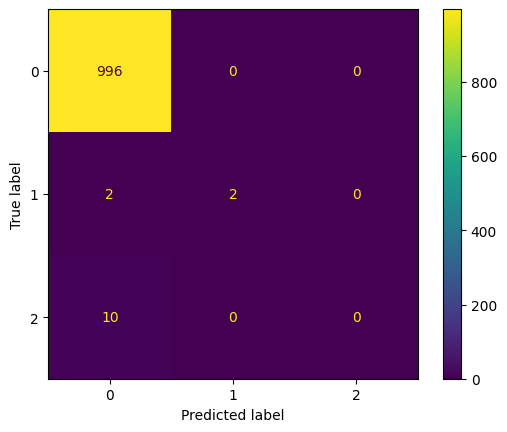

In [94]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

Eventually, try with usual random forest with changed scoring : f1_macro

In [118]:
df = pd.read_csv('data/phl_data.csv') 

In [119]:
col_to_drop = ['P_NAME', 'S_NAME', 'S_CONSTELLATION', 'P_YEAR', 'S_RA', 'S_DEC', 'hip_name', 'hd_name', 'matched']
df.drop(col_to_drop, axis=1, inplace=True)
df = remove_col(df)

# Remove NaN in P_ESI

df.dropna(subset=['P_ESI'], inplace=True)

Numeric columns dropped: []
Non-numeric columns dropped: ['S_TYPE']


In [120]:
# Split the data into training and testing sets
X = df.drop(['P_ESI', 'P_HABITABLE', 'P_HABZONE_CON', 'P_HABZONE_OPT'], axis = 1)
y = df[['P_HABITABLE']]

# Remove 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

nan_indices_train = X_train[X_train['P_DETECTION'].isna()].index
nan_indices_test = X_test[X_test['P_DETECTION'].isna()].index

# Dropping the NaN rows from X_train, X_test, y_train, and y_test
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

X_test = X_test.drop(nan_indices_test)
y_test = y_test.drop(nan_indices_test)

In [121]:
# Fitting pipeline on training data 

preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('mice_imputation',
                                                  IterativeImputer(random_state=17)),
                                                 ('scaler', StandardScaler())]),
                                 ['P_MASS', 'P_RADIUS', 'P_PERIOD',
                                  'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY',
                                  'P_INCLINATION', 'P_IMPACT_PARAMETER',
                                  'P_FLUX', 'P_DISTANCE', 'P_DENSITY',
                                  'P_GRAVITY', 'S_MAG', 'S_DISTANCE',
                                  'S_METALLICITY', 'S_MASS', 'S_RADIUS',
                                  'S_AGE', 'S_TEMPERATURE', 'S_LUMINOSITY']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  ColumnTransformer(transformers=[('one_hot',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['P_TYPE_TEMP',
                                                                                    'P_TYPE']),
                                                                                  ('frequency',
                                                                                   FrequencyEncoder(),
                                                                                   ['P_DETECTION'])]))]),
                                 ['P_DETECTION', 'P_TYPE_TEMP', 'P_TYPE'])])

In [122]:
# using it on training and testing data

prep_train = preprocessor.transform(X_train)
X_train_df = pd.DataFrame(prep_train, index=y_train.index)
X_train_df['P_HABITABLE'] = y_train
X_train_df.dropna(inplace=True)
X_train_df.columns = X_train_df.columns.astype(str)

prep_test = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(prep_test, index=y_test.index)
X_test_df['P_HABITABLE'] = y_test
X_test_df.dropna(inplace=True)
X_test_df.columns = X_test_df.columns.astype(str)

In [123]:
X_train = X_train_df.drop(['P_HABITABLE'], axis = 1)
y_train = X_train_df[['P_HABITABLE']]

X_test = X_test_df.drop(['P_HABITABLE'], axis = 1)
y_test = X_test_df[['P_HABITABLE']]

In [124]:
model_fitted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=17).fit(X_train, y_train)

# Evaluation of the model

y_pred = model_fitted.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

c:\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.0009900990099009901


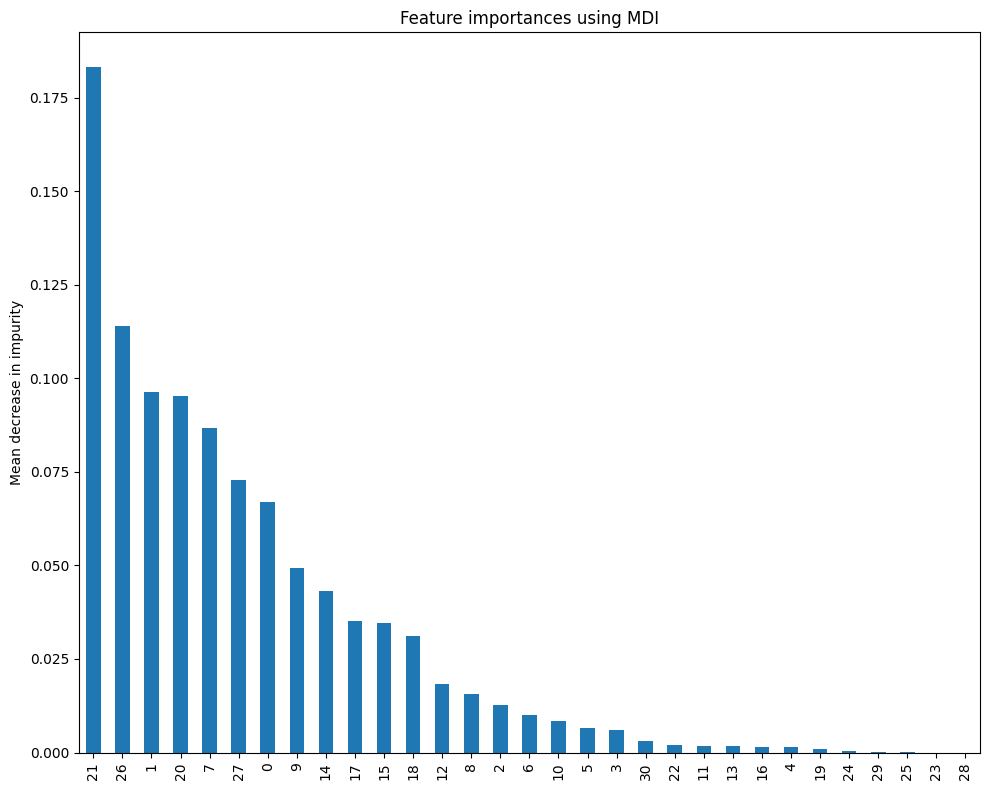

In [126]:
# Feature importance

importances = model_fitted.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Plot

fig, ax = plt.subplots(figsize=(10,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [127]:
X_train_df = X_train_df[['21', '26', '1', '20', '7', '27', '0', '9', '14', '17', '15', '18']]
X_test_df = X_test_df[['21', '26', '1', '20', '7', '27', '0', '9', '14', '17', '15', '18']]

In [128]:
srf = RandomForestClassifier(random_state=17, class_weight='balanced')
cv_folds = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=17)

algorithm_params = {'n_estimators': list(range(100,500,50)),
                 'max_depth': list(range(3,20,2)),
                 'min_samples_split': list(range(2,20)), 
                 'min_samples_leaf': list(range(1,20)),
}

In [133]:
bayesian_search = BayesSearchCV(srf, algorithm_params, cv = cv_folds, scoring='f1_macro',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_train, y_train)

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

c:\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters: OrderedDict([('max_depth', 17), ('min_samples_leaf', 1), ('min_samples_split', 7), ('n_estimators', 400)])


In [140]:
y_pred = best_model.predict(X_test)
# Evaluate model performance
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
f1_score_ = f1_score(y_true = y_test.astype(float), y_pred=y_pred.astype(float), average='macro')
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")
print(f'f1 score : {f1_score_}')

Model Accuracy : 0.999009900990099
Model Precision : 1.0 
Model Sensitivity : 0.75 
f1 score : 0.9522137003321148


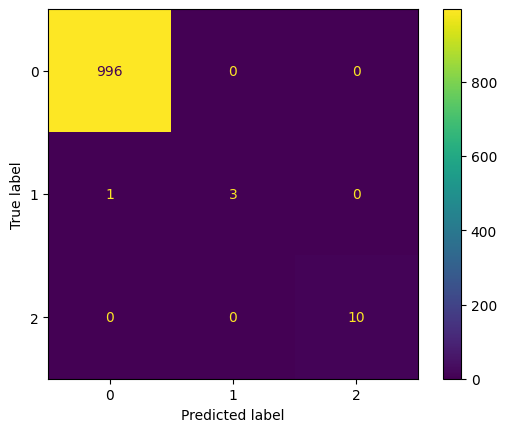

In [135]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

XGBosst with F1-Score

In [136]:
xgb_model = xgb.XGBClassifier()
cv_folds = KFold(n_splits=5, shuffle=True, random_state=17)

algorithm_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],  
    "max_depth": list(range(3, 13)), 
    "min_child_weight": list(range(1, 10)), 
    "gamma": [0.0, 0.05, 0.1, 0.15, 0.2],  
    "colsample_bytree": [i/10.0 for i in range(3, 11)]  
}

In [141]:
bayesian_search = BayesSearchCV(xgb_model, algorithm_params, cv = cv_folds, scoring='f1_macro',random_state=17,n_iter=100,n_jobs=-1)
bayesian_search.fit(X_train, y_train)

best_model = bayesian_search.best_estimator_
print("Best parameters:", bayesian_search.best_params_)

Best parameters: OrderedDict([('colsample_bytree', 0.9), ('gamma', 0.1), ('learning_rate', 0.35), ('max_depth', 7), ('min_child_weight', 1)])


In [149]:
y_pred = best_model.predict(X_test)
# Evaluate model performance
accuracy = accuracy_score(y_test.astype(float), y_pred.astype(float))
conf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))
precision=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[0, 1])
sensitivity=conf_matrix[1, 1]/(conf_matrix[1, 1]+conf_matrix[1, 0])
print(f"Model Accuracy : {accuracy}")
print(f"Model Precision : {precision} ")
print(f"Model Sensitivity : {sensitivity} ")

Model Accuracy : 1.0
Model Precision : 1.0 
Model Sensitivity : 1.0 


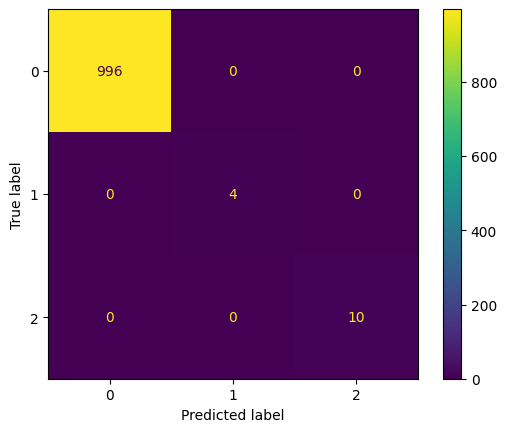

In [150]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

P_TEMP_EQUIL

Here, I will try to use a small Neural Network to predict the Equilibrium Temperature of a planet, which is of great importance for the presence of life, its evolution, as it can suggests the presence of an atmosphere.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(17)

In [14]:
df = pd.read_csv('data/phl_data.csv') 

<AxesSubplot: xlabel='P_TEMP_EQUIL', ylabel='Count'>

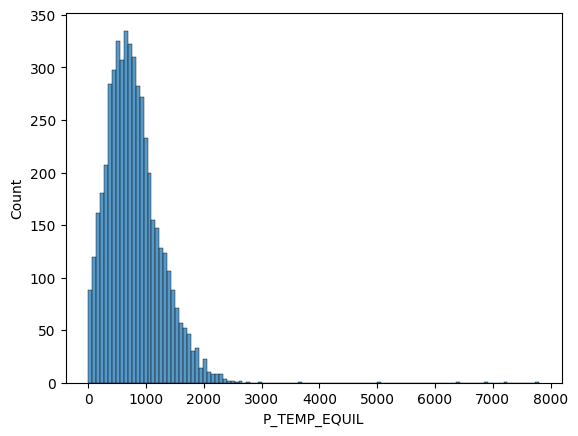

In [15]:
sns.histplot(df, x = 'P_TEMP_EQUIL')

In [102]:
col_to_drop = ['P_NAME', 'S_NAME', 'S_CONSTELLATION', 'P_YEAR', 'S_RA', 'S_DEC', 'hip_name', 'hd_name', 'matched', 'P_TYPE', 'P_TYPE_TEMP']
df.drop(col_to_drop, axis=1, inplace=True)
df = remove_col(df)

# Remove NaN in P_ESI

df.dropna(subset=['P_TEMP_EQUIL'], inplace=True)

Numeric columns dropped: []
Non-numeric columns dropped: ['S_TYPE']


In [103]:
# Split the data into training and testing sets
X = df.drop(['P_HABZONE_CON', 'P_HABZONE_OPT', 'P_TEMP_EQUIL', 'P_ESI', 'P_HABITABLE'], axis = 1)
y = df[['P_TEMP_EQUIL']]

# Remove 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=17)

nan_indices_train = X_train[X_train['P_DETECTION'].isna()].index
nan_indices_val = X_val[X_val['P_DETECTION'].isna()].index

# Dropping the NaN rows from X_train, X_test, y_train, and y_test
X_train = X_train.drop(nan_indices_train)
y_train = y_train.drop(nan_indices_train)

X_val = X_val.drop(nan_indices_val)
y_val = y_val.drop(nan_indices_val)

In [104]:
# The two pipelines, for numerical and categorical features (and the different encoders)

numerical_pipeline = Pipeline(
    steps=[
        ('mice_imputation', IterativeImputer(random_state=17, max_iter=10)),
        ('scaler', StandardScaler())]
)

categorical_pipeline = Pipeline([
    ('encoder', ColumnTransformer(
        transformers=[
            ('frequency', ce.CountEncoder(normalize=True), ['P_DETECTION'])
        ],
    ))
])

# Combine the two pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, ['P_RADIUS', 'P_MASS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION', 'P_IMPACT_PARAMETER', 'P_FLUX', 'P_DISTANCE', 'P_DENSITY', 'P_GRAVITY', 'S_MAG', 'S_DISTANCE', 'S_METALLICITY', 'S_MASS', 'S_RADIUS', 'S_AGE','S_LUMINOSITY', 'S_TEMPERATURE']),
        ('categorical', categorical_pipeline, ['P_DETECTION']),
    ],
    remainder='passthrough'
)

In [105]:
preprocessor.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('mice_imputation',
                                                  IterativeImputer(random_state=17)),
                                                 ('scaler', StandardScaler())]),
                                 ['P_RADIUS', 'P_MASS', 'P_PERIOD',
                                  'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY',
                                  'P_INCLINATION', 'P_IMPACT_PARAMETER',
                                  'P_FLUX', 'P_DISTANCE', 'P_DENSITY',
                                  'P_GRAVITY', 'S_MAG', 'S_DISTANCE',
                                  'S_METALLICITY', 'S_MASS', 'S_RADIUS',
                                  'S_AGE', 'S_LUMINOSITY', 'S_TEMPERATURE']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  ColumnTransformer(transformers=[('frequency',
                                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                                normalize=True),
                                                                                   ['P_DETECTION'])]))]),
                                 ['P_DETECTION'])])

In [106]:
# using it on training and testing data

prep_train = preprocessor.transform(X_train)
X_train_df = pd.DataFrame(prep_train, index=y_train.index)
X_train_df['P_TEMP_EQUIL'] = y_train
X_train_df.dropna(inplace=True)
X_train_df.columns = X_train_df.columns.astype(str)

prep_val = preprocessor.transform(X_val)
X_val_df = pd.DataFrame(prep_val, index=y_val.index)
X_val_df['P_TEMP_EQUIL'] = y_val
X_val_df.dropna(inplace=True)
X_val_df.columns = X_val_df.columns.astype(str)

In [107]:
X_train = X_train_df.iloc[:,0:21]
y_train = X_train_df.iloc[:,21]

In [108]:
X_val = X_val_df.iloc[:,0:21]
y_val = X_val_df.iloc[:,21]

In [109]:
X_train_t = torch.from_numpy(X_train.to_numpy(np.float32))
X_val_t = torch.from_numpy(X_val.to_numpy(np.float32))

In [110]:
y_train_t = torch.from_numpy(y_train.to_numpy(np.float32))
y_val_t = torch.from_numpy(y_val.to_numpy(np.float32))

In [111]:
trn_ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=10, shuffle=True)

val_ds = torch.utils.data.TensorDataset(X_val_t, y_val_t)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=10, shuffle=True)

In [112]:
model = nn.Sequential(
    nn.Linear(X_train_t.shape[1], 1000),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(1000, 300),
    nn.ReLU(),
    nn.Dropout(.5), 
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

In [113]:
model

Sequential(
  (0): Linear(in_features=21, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=300, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=300, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=1, bias=True)
)

In [114]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

352501


In [115]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

352501


In [116]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [117]:
from tqdm import tqdm

In [118]:
train_losses = []
val_losses = []

n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for Xb, yb in tqdm(trn_dl):
        yb_pred = model(Xb)
        loss = loss_fn(yb_pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_dl:
            yb_pred = model(Xb)
            val_loss += loss_fn(yb_pred, yb).item()

    avg_train_loss = train_loss / len(trn_dl)
    avg_val_loss = val_loss / len(val_dl)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

  0%|          | 0/304 [00:00<?, ?it/s]

C:\Users\Utilisateur\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 298/304 [00:03<00:00, 87.68it/s]C:\Users\Utilisateur\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 304/304 [00:03<00:00, 86.63it/s]


Epoch 0: Train Loss: 771865.6677920693, Validation Loss: 1937445.204014542


100%|██████████| 304/304 [00:03<00:00, 80.33it/s]


Epoch 1: Train Loss: 368512.58155662136, Validation Loss: 3316972.2621441833


100%|██████████| 304/304 [00:04<00:00, 68.20it/s]


Epoch 2: Train Loss: 312909.4247982628, Validation Loss: 2615062.1657448946


100%|██████████| 304/304 [00:10<00:00, 28.13it/s]


Epoch 3: Train Loss: 301604.55128238077, Validation Loss: 2108043.9173499383


100%|██████████| 304/304 [00:09<00:00, 32.56it/s]


Epoch 4: Train Loss: 288033.4205001028, Validation Loss: 1740933.6689936572


100%|██████████| 304/304 [00:12<00:00, 24.53it/s]


Epoch 5: Train Loss: 283096.1568282278, Validation Loss: 1555439.2057452817


100%|██████████| 304/304 [00:13<00:00, 22.27it/s]


Epoch 6: Train Loss: 274496.68753854855, Validation Loss: 1355750.4760403775


100%|██████████| 304/304 [00:15<00:00, 20.22it/s]


Epoch 7: Train Loss: 266616.209948088, Validation Loss: 1251735.8121325804


100%|██████████| 304/304 [00:09<00:00, 31.47it/s]


Epoch 8: Train Loss: 266761.1325683594, Validation Loss: 1081433.9396465037


100%|██████████| 304/304 [00:08<00:00, 37.29it/s]


Epoch 9: Train Loss: 263792.9723085102, Validation Loss: 917452.4306157178


100%|██████████| 304/304 [00:05<00:00, 58.07it/s]


Epoch 10: Train Loss: 258926.50481214022, Validation Loss: 853282.2981512995


100%|██████████| 304/304 [00:05<00:00, 53.01it/s]


Epoch 11: Train Loss: 256856.11825240287, Validation Loss: 739364.0892829518


100%|██████████| 304/304 [00:05<00:00, 52.95it/s]


Epoch 12: Train Loss: 258973.82074295846, Validation Loss: 721483.6893370978


100%|██████████| 304/304 [00:06<00:00, 49.86it/s]


Epoch 13: Train Loss: 256392.1904553865, Validation Loss: 672045.8755994741


100%|██████████| 304/304 [00:05<00:00, 50.96it/s]


Epoch 14: Train Loss: 254725.7373882093, Validation Loss: 582270.7467512377


100%|██████████| 304/304 [00:04<00:00, 67.33it/s]


Epoch 15: Train Loss: 253649.8576274671, Validation Loss: 551935.628596844


100%|██████████| 304/304 [00:05<00:00, 55.11it/s]


Epoch 16: Train Loss: 251113.45166979337, Validation Loss: 532809.8260751857


100%|██████████| 304/304 [00:05<00:00, 55.27it/s]


Epoch 17: Train Loss: 252558.7125051398, Validation Loss: 490438.40884127474


100%|██████████| 304/304 [00:04<00:00, 65.33it/s]


Epoch 18: Train Loss: 251335.11564234682, Validation Loss: 460554.53741878096


100%|██████████| 304/304 [00:05<00:00, 60.40it/s]


Epoch 19: Train Loss: 251158.74911338405, Validation Loss: 456173.0984491027


100%|██████████| 304/304 [00:04<00:00, 63.16it/s]


Epoch 20: Train Loss: 250542.76593338815, Validation Loss: 430332.0770420792


100%|██████████| 304/304 [00:05<00:00, 59.54it/s]


Epoch 21: Train Loss: 251128.56127929688, Validation Loss: 425469.3193069307


100%|██████████| 304/304 [00:04<00:00, 69.54it/s]


Epoch 22: Train Loss: 253194.53195672287, Validation Loss: 438469.5637182859


100%|██████████| 304/304 [00:04<00:00, 68.82it/s]


Epoch 23: Train Loss: 249605.4961901213, Validation Loss: 404976.17318030633


100%|██████████| 304/304 [00:04<00:00, 66.48it/s]


Epoch 24: Train Loss: 249824.6857139186, Validation Loss: 411673.91744662746


100%|██████████| 304/304 [00:04<00:00, 62.04it/s]


Epoch 25: Train Loss: 249355.9234426398, Validation Loss: 398816.7044593131


100%|██████████| 304/304 [00:05<00:00, 60.56it/s]


Epoch 26: Train Loss: 248403.81998483758, Validation Loss: 398744.0068649443


100%|██████████| 304/304 [00:07<00:00, 40.25it/s]


Epoch 27: Train Loss: 248726.3742033306, Validation Loss: 411493.0780283107


100%|██████████| 304/304 [00:15<00:00, 19.17it/s]


Epoch 28: Train Loss: 248813.1957943565, Validation Loss: 376194.6548576733


100%|██████████| 304/304 [00:13<00:00, 23.05it/s]


Epoch 29: Train Loss: 248813.35206363077, Validation Loss: 348231.17063737626


100%|██████████| 304/304 [00:15<00:00, 19.26it/s]


Epoch 30: Train Loss: 247859.07163037753, Validation Loss: 369389.33622756804


100%|██████████| 304/304 [00:09<00:00, 32.52it/s]


Epoch 31: Train Loss: 248214.1540655839, Validation Loss: 339617.07568842825


100%|██████████| 304/304 [00:14<00:00, 21.50it/s]


Epoch 32: Train Loss: 247218.94229286595, Validation Loss: 342155.735883354


100%|██████████| 304/304 [00:17<00:00, 17.49it/s]


Epoch 33: Train Loss: 247248.83795487252, Validation Loss: 363268.21347076114


100%|██████████| 304/304 [00:14<00:00, 21.15it/s]


Epoch 34: Train Loss: 246949.86198344984, Validation Loss: 356851.75389658107


100%|██████████| 304/304 [00:16<00:00, 18.22it/s]


Epoch 35: Train Loss: 246336.06959292764, Validation Loss: 347923.45269956684


100%|██████████| 304/304 [00:15<00:00, 19.97it/s]


Epoch 36: Train Loss: 247307.63326223273, Validation Loss: 365103.68363242573


100%|██████████| 304/304 [00:10<00:00, 29.79it/s]


Epoch 37: Train Loss: 247420.39658717104, Validation Loss: 325469.7218440594


100%|██████████| 304/304 [00:11<00:00, 26.03it/s]


Epoch 38: Train Loss: 247824.04221062912, Validation Loss: 349000.4421314202


100%|██████████| 304/304 [00:30<00:00, 10.07it/s]


Epoch 39: Train Loss: 248470.4171977796, Validation Loss: 330079.24293200806


100%|██████████| 304/304 [00:13<00:00, 23.09it/s]


Epoch 40: Train Loss: 247718.64967105264, Validation Loss: 329816.59813969675


100%|██████████| 304/304 [00:12<00:00, 24.58it/s]


Epoch 41: Train Loss: 248771.01177014803, Validation Loss: 342290.92025061883


100%|██████████| 304/304 [00:13<00:00, 22.99it/s]


Epoch 42: Train Loss: 247095.51701917147, Validation Loss: 310915.7986154084


100%|██████████| 304/304 [00:10<00:00, 29.58it/s]


Epoch 43: Train Loss: 246627.4923802426, Validation Loss: 317257.53208152845


100%|██████████| 304/304 [00:15<00:00, 19.28it/s]


Epoch 44: Train Loss: 246737.7574013158, Validation Loss: 327374.1050626547


100%|██████████| 304/304 [00:20<00:00, 14.51it/s]


Epoch 45: Train Loss: 245793.1226356908, Validation Loss: 333298.5152382426


100%|██████████| 304/304 [00:10<00:00, 29.44it/s]


Epoch 46: Train Loss: 246858.1668508429, Validation Loss: 335652.8172957921


100%|██████████| 304/304 [00:15<00:00, 19.65it/s]


Epoch 47: Train Loss: 246646.349583676, Validation Loss: 363724.11196627474


100%|██████████| 304/304 [00:07<00:00, 39.84it/s]


Epoch 48: Train Loss: 247362.238255551, Validation Loss: 319592.5880259901


100%|██████████| 304/304 [00:17<00:00, 17.75it/s]


Epoch 49: Train Loss: 250345.92255602384, Validation Loss: 341014.76094523515


100%|██████████| 304/304 [00:13<00:00, 21.77it/s]


Epoch 50: Train Loss: 247815.3783023232, Validation Loss: 331585.9395111386


100%|██████████| 304/304 [00:14<00:00, 21.26it/s]


Epoch 51: Train Loss: 246169.67434210525, Validation Loss: 342291.9834564511


100%|██████████| 304/304 [00:13<00:00, 23.36it/s]


Epoch 52: Train Loss: 244968.87184223376, Validation Loss: 323023.46372215345


100%|██████████| 304/304 [00:08<00:00, 36.99it/s]


Epoch 53: Train Loss: 245233.0684428968, Validation Loss: 320298.9525642017


100%|██████████| 304/304 [00:07<00:00, 39.34it/s]


Epoch 54: Train Loss: 246323.48900082236, Validation Loss: 321554.29949528154


100%|██████████| 304/304 [00:11<00:00, 25.97it/s]


Epoch 55: Train Loss: 245813.08655427632, Validation Loss: 322478.02196782175


100%|██████████| 304/304 [00:11<00:00, 26.67it/s]


Epoch 56: Train Loss: 245191.19815705952, Validation Loss: 328760.206876547


100%|██████████| 304/304 [00:04<00:00, 67.85it/s]


Epoch 57: Train Loss: 245806.5378931949, Validation Loss: 326176.0390625


100%|██████████| 304/304 [00:04<00:00, 64.88it/s]


Epoch 58: Train Loss: 245872.87417763157, Validation Loss: 342312.0969987624


100%|██████████| 304/304 [00:04<00:00, 62.98it/s]


Epoch 59: Train Loss: 245223.17867499904, Validation Loss: 324528.7643003558


100%|██████████| 304/304 [00:04<00:00, 64.54it/s]


Epoch 60: Train Loss: 246564.5763389186, Validation Loss: 315508.6197981126


100%|██████████| 304/304 [00:04<00:00, 63.60it/s]


Epoch 61: Train Loss: 245645.79854543586, Validation Loss: 350482.06736347463


100%|██████████| 304/304 [00:04<00:00, 74.84it/s]


Epoch 62: Train Loss: 247642.6666195518, Validation Loss: 329974.0815671411


100%|██████████| 304/304 [00:04<00:00, 74.39it/s]


Epoch 63: Train Loss: 247022.40270353618, Validation Loss: 344809.9407874381


100%|██████████| 304/304 [00:04<00:00, 66.24it/s]


Epoch 64: Train Loss: 245829.70794356498, Validation Loss: 324043.9422571163


100%|██████████| 304/304 [00:04<00:00, 64.27it/s]


Epoch 65: Train Loss: 245073.7490812603, Validation Loss: 299276.8377939357


100%|██████████| 304/304 [00:04<00:00, 70.22it/s]


Epoch 66: Train Loss: 244953.90009508634, Validation Loss: 312017.63604192453


100%|██████████| 304/304 [00:04<00:00, 66.38it/s]


Epoch 67: Train Loss: 246576.4212710732, Validation Loss: 325928.69188969675


100%|██████████| 304/304 [00:04<00:00, 64.54it/s]


Epoch 68: Train Loss: 245387.89020739103, Validation Loss: 351818.97472540225


100%|██████████| 304/304 [00:04<00:00, 64.78it/s]


Epoch 69: Train Loss: 245825.26305509868, Validation Loss: 341822.83972772275


100%|██████████| 304/304 [00:04<00:00, 62.94it/s]


Epoch 70: Train Loss: 244970.37010433798, Validation Loss: 339136.38566483604


100%|██████████| 304/304 [00:03<00:00, 80.98it/s]


Epoch 71: Train Loss: 246384.54807000412, Validation Loss: 342471.80950262997


100%|██████████| 304/304 [00:04<00:00, 64.94it/s]


Epoch 72: Train Loss: 246173.57642886514, Validation Loss: 328888.25123762374


100%|██████████| 304/304 [00:06<00:00, 44.90it/s]


Epoch 73: Train Loss: 245580.00076916342, Validation Loss: 355190.8567643874


100%|██████████| 304/304 [00:16<00:00, 17.91it/s]


Epoch 74: Train Loss: 246219.07766241775, Validation Loss: 314951.54735844675


100%|██████████| 304/304 [00:16<00:00, 18.19it/s]


Epoch 75: Train Loss: 244685.28265059623, Validation Loss: 338366.32158879953


100%|██████████| 304/304 [00:13<00:00, 22.74it/s]


Epoch 76: Train Loss: 246008.5752210115, Validation Loss: 342332.24998066213


100%|██████████| 304/304 [00:16<00:00, 18.63it/s]


Epoch 77: Train Loss: 245642.61123817845, Validation Loss: 316578.71285194927


100%|██████████| 304/304 [00:12<00:00, 25.01it/s]


Epoch 78: Train Loss: 245336.0911986671, Validation Loss: 324656.6576133199


100%|██████████| 304/304 [00:16<00:00, 18.75it/s]


Epoch 79: Train Loss: 244640.451666581, Validation Loss: 307569.9728689666


100%|██████████| 304/304 [00:15<00:00, 19.24it/s]


Epoch 80: Train Loss: 246361.525364926, Validation Loss: 325884.49170405325


100%|██████████| 304/304 [00:15<00:00, 20.04it/s]


Epoch 81: Train Loss: 245962.90170127468, Validation Loss: 317265.6743405786


100%|██████████| 304/304 [00:15<00:00, 19.04it/s]


Epoch 82: Train Loss: 244380.32488692435, Validation Loss: 298698.00017404085


100%|██████████| 304/304 [00:11<00:00, 25.36it/s]


Epoch 83: Train Loss: 245841.3179738898, Validation Loss: 300791.6050819926


100%|██████████| 304/304 [00:10<00:00, 28.80it/s]


Epoch 84: Train Loss: 245277.13820929275, Validation Loss: 321010.24287399446


100%|██████████| 304/304 [00:12<00:00, 24.34it/s]


Epoch 85: Train Loss: 244721.3380030582, Validation Loss: 317213.4701906714


100%|██████████| 304/304 [00:15<00:00, 19.89it/s]


Epoch 86: Train Loss: 244232.5189658717, Validation Loss: 349730.1456915223


100%|██████████| 304/304 [00:13<00:00, 22.54it/s]


Epoch 87: Train Loss: 245051.62917930202, Validation Loss: 333778.96051206684


100%|██████████| 304/304 [00:15<00:00, 19.44it/s]


Epoch 88: Train Loss: 244637.07862613077, Validation Loss: 321682.9793664913


100%|██████████| 304/304 [00:13<00:00, 22.87it/s]


Epoch 89: Train Loss: 245020.0050755551, Validation Loss: 314812.4522547958


100%|██████████| 304/304 [00:19<00:00, 15.60it/s]


Epoch 90: Train Loss: 245274.01484439248, Validation Loss: 309363.9466081374


100%|██████████| 304/304 [00:05<00:00, 60.03it/s]


Epoch 91: Train Loss: 245489.5751696135, Validation Loss: 330562.3595103651


100%|██████████| 304/304 [00:04<00:00, 61.54it/s]


Epoch 92: Train Loss: 244372.19211297287, Validation Loss: 322946.46258121904


100%|██████████| 304/304 [00:05<00:00, 60.51it/s]


Epoch 93: Train Loss: 245038.48865549188, Validation Loss: 341065.2894976021


100%|██████████| 304/304 [00:04<00:00, 67.10it/s]


Epoch 94: Train Loss: 244997.96994500412, Validation Loss: 344027.3395730198


100%|██████████| 304/304 [00:05<00:00, 52.19it/s]


Epoch 95: Train Loss: 244678.0129844264, Validation Loss: 334529.508411974


100%|██████████| 304/304 [00:05<00:00, 53.23it/s]


Epoch 96: Train Loss: 244828.80498946342, Validation Loss: 351917.64064433787


100%|██████████| 304/304 [00:05<00:00, 55.27it/s]


Epoch 97: Train Loss: 244886.29102847452, Validation Loss: 321020.82588180696


100%|██████████| 304/304 [00:04<00:00, 72.61it/s]


Epoch 98: Train Loss: 245864.87575812088, Validation Loss: 292823.44627939357


100%|██████████| 304/304 [00:04<00:00, 68.54it/s]


Epoch 99: Train Loss: 245177.15417681242, Validation Loss: 296968.6568107983


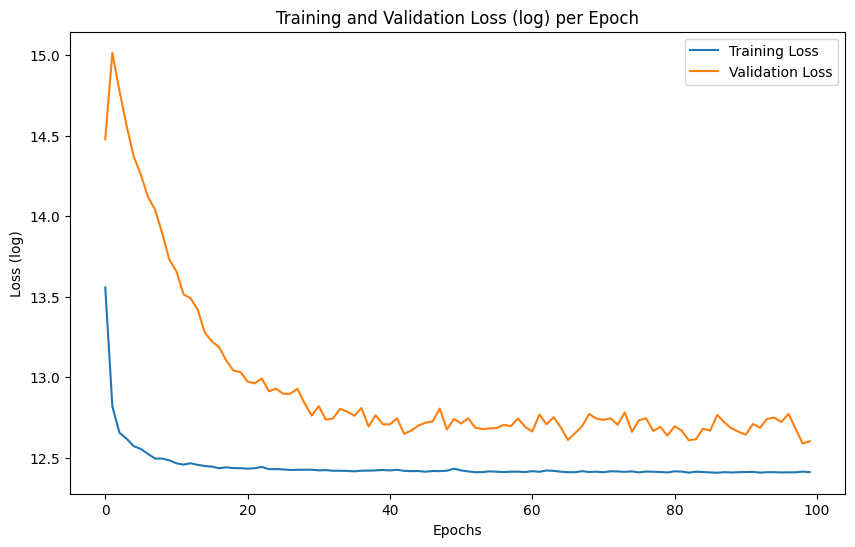

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(np.log(train_losses), label='Training Loss')
plt.plot(np.log(val_losses), label='Validation Loss')
plt.title('Training and Validation Loss (log) per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss (log)')
plt.legend()
plt.show()